# Jet matching using pre-made functions (4900101)
## Here we use pre-made functions as found in jet_matching_functions.py . uproot is used to handle the read in of .root files without the need of having ROOT installed locally. The library can actually be used to write-out now as well, but this is not used here.

In [1]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import mplhep as hep

from collections import Counter
from jet_matching_functions import *

In [2]:
# set plot style
plt.style.use([hep.style.ATLAS,
                   {'font.sans-serif': ['Tex Gyre Heros']},  # use when helvetica isn't installed
                   {'errorbar.capsize': 5},
                   {'axes.labelsize': 23},
                   {'axes.labelpad': 23},
    ])


Below we use a sample of 10,000 events from an ntuple made by the xAOD framework (with our extra truth package added)

In [3]:
fname = 'DAODtoNTUPLE_10000.root'
file = uproot.open(fname)

Output the branches we have in our ROOT file. Note here that we have a4, a10 and a15 samples which refer to anti-kt algorithm with R = 0.4, 1.0 and reconstructed 1.5 resepectively. <br />
MET_Truth_met is the Truth MET information, truthBSM_*variable* refers to some truthBSM particle information

In [4]:
file['outTree;1']['nominal'].keys()

[b'runNumber',
 b'eventNumber',
 b'lumiBlock',
 b'coreFlags',
 b'bcid',
 b'mcEventNumber',
 b'mcChannelNumber',
 b'mcEventWeight',
 b'mcEventWeights',
 b'timeStamp',
 b'timeStampNSOffset',
 b'TileError',
 b'SCTError',
 b'LArError',
 b'TileFlags',
 b'SCTFlags',
 b'LArFlags',
 b'eventClean_LooseBad',
 b'NPV',
 b'actualInteractionsPerCrossing',
 b'averageInteractionsPerCrossing',
 b'weight_pileup',
 b'correctedAverageMu',
 b'correctedAndScaledAverageMu',
 b'correctedActualMu',
 b'correctedAndScaledActualMu',
 b'weight_pileup_up',
 b'weight_pileup_down',
 b'rand_run_nr',
 b'rand_lumiblock_nr',
 b'passL1',
 b'passHLT',
 b'passedTriggers',
 b'disabledTriggers',
 b'na4_pflowjets_raw',
 b'a4_pflowjets_raw_E',
 b'a4_pflowjets_raw_pt',
 b'a4_pflowjets_raw_phi',
 b'a4_pflowjets_raw_eta',
 b'a4_pflowjets_raw_clean_passLooseBad',
 b'a4_pflowjets_raw_clean_passTightBad',
 b'a4_pflowjets_raw_numConstituents',
 b'a4_pflowjets_raw_ConeTruthLabelID',
 b'a4_pflowjets_raw_TruthCount',
 b'a4_pflowjets_raw_

Sets the tree we want to look at (nominal is the interesting one!)

In [5]:
tree = file['outTree']['nominal']

Make a few variables that pertain to the truth information we have 

In [6]:
numBSM_truth = tree.array('ntruthBSM')
truthBSM_pdgIDs = tree.array('truthBSM_pdgId')
truthBSM_status = tree.array('truthBSM_status')
truthBSM_barcode = tree.array('truthBSM_barcode')
truthBSM_px = tree.array('truthBSM_px')
truthBSM_py = tree.array('truthBSM_py')
truthBSM_pz = tree.array('truthBSM_pz')
truthBSM_m = tree.array('truthBSM_m')
truthBSM_pt = tree.array('truthBSM_pt')

## Functions to be used
Here we define the functions that will aid in visualization and matching. These can be found in the jet_matching_functions.py, but for ease of modification of values (xlim, ylim, etc.) they are included here as well <br />
- make_truth_matched_var: this takes the variable we are interested in and looks for the value and position in the deltaR_lt_pos. deltaR_lt refers to the deltaR less than whatever value is set for it <br />
- make_plot_data: takes in the truth matched data and makes the data that is to be plotted <br />
- atlas_plotter: handles plotting in an ATLAS style <br />
- jet_match: handles the actual jet matching based on truth and reconstructed collections of values. We also set our deltaR limit here. For R=0.4, a deltaR limit of 0.2 is used, for example

In [7]:
def make_truth_matched_var(deltaR_lt_pos, var):
    truth_match_var = []
    for i in range(len(deltaR_lt_pos)):
        temp = []
        try:
            for j in deltaR_lt_pos[i]:
                if deltaR_lt_pos[i] != []:
                    temp.append(var[j[0], j[1]])
                else:
                    temp.append(-999)
        except:
            temp.append(-999)

        truth_match_var.append(temp)

    return truth_match_var

In [8]:
def make_plot_data(truth_matched_var):
    data = []
    for i in range(len(truth_matched_var)):
        for j in truth_matched_var[i]:
            data.append(j)
    return data

In [9]:
def atlas_plotter(data, xlabel, legend = '', title = '',bins = 'auto', ylabel = 'Count', 
                  color = 'blue', xlim = (0, 0), ylim = (0, 0), save_plot = False, binwidth = None):
    # set plot style
    plt.style.use([hep.style.ATLAS,
                   {'font.sans-serif': ['Tex Gyre Heros']},  # use when helvetica isn't installed
                   {'errorbar.capsize': 5},
                   {'axes.labelsize': 23},
                   {'axes.labelpad': 23},
    ])

    plt.figure(figsize = (10, 7))
    plt.title(title)
    plt.xlabel(xlabel)
    if xlim != (0, 0):
        plt.xlim(xlim)
    if ylim != (0, 0):
        plt.ylim(ylim)
    sns.histplot(data, bins = bins, color = color, binwidth = binwidth, label = legend)
    plt.legend()

    plt.show()
    if save_plot:
        save_path = title + '.png'
        plt.savefig(save_path)

In [10]:
def jet_match(tree, truth_col, reco_col, deltaR_lim = 0.2):
#set the number of jets we want to loop over 
    num_jets = 4
#define our collection strings
    tru_e = truth_col + '_e'
    tru_pt = truth_col + '_pt'
    tru_phi = truth_col + '_phi'
    tru_eta = truth_col + '_eta'

    rec_pt = reco_col + '_pt'
    rec_phi = reco_col + '_phi'
    rec_eta = reco_col + '_eta'

#make arrays from those collections
    truth_col_e = tree.array(tru_e)
    truth_col_pt = tree.array(tru_pt)
    truth_col_phi = tree.array(tru_phi)
    truth_col_eta = tree.array(tru_eta)

    reco_col_pt = tree.array(rec_pt)
    reco_col_phi = tree.array(rec_phi)
    reco_col_eta = tree.array(rec_eta)

#make the deltaR and deltaR positions arrays
    deltaR_lt = []
    deltaR_lt_pos = []
    for event in range(len(reco_col_phi)):
        temp1 = []
        temp2 = []
        try:
            for jet in range(num_jets):
                for obj in range(len(truth_col_phi[event])):
                    delta_phi = truth_col_phi[event][obj] - reco_col_phi[event][jet]
                    delta_eta = truth_col_eta[event][obj] - reco_col_eta[event][jet]
                    
                    delta_phi_sqrd = delta_phi ** 2
                    delta_eta_sqrd = delta_eta ** 2

                    deltaR_sqrd = delta_phi_sqrd + delta_eta_sqrd
                    deltaR = deltaR_sqrd ** 0.5

                    deltaR_lim = deltaR_lim
                    if deltaR <= deltaR_lim:
                        temp1.append([jet, deltaR])
                        temp2.append([jet, event, obj])
                    else:
                        continue
            deltaR_lt.append(temp1)
            deltaR_lt_pos.append(temp2)
        except:
            deltaR_lt.append([-999, -999])
            deltaR_lt_pos.append([-999, -999])


#number of matched per jet graph
    #save_plot = False
    num_deltaR_lt_1 = []
    num_deltaR_lt_2 = []
    num_deltaR_lt_3 = []
    num_deltaR_lt_4 = []
    for i in range(len(deltaR_lt)):
        temp1 = 0
        temp2 = 0
        temp3 = 0
        temp4 = 0
        try:
            for j in range(len(deltaR_lt[i])):
                if deltaR_lt[i][j][0] == 0:
                    temp1+=1
                elif deltaR_lt[i][j][0] == 1:
                    temp2+=1
                elif deltaR_lt[i][j][0] == 2:
                    temp3+=1
                elif deltaR_lt[i][j][0] == 3:
                    temp4+=1
                    
            num_deltaR_lt_1.append(temp1)
            num_deltaR_lt_2.append(temp2)
            num_deltaR_lt_3.append(temp3)
            num_deltaR_lt_4.append(temp4)
        except:
            continue
            
    #title = 'Number of Truth Matched Particles per Event Histogram Plot: '+truth_col+' vs '+reco_col
    #xlabel = 'Num. Jets'
    #atlas_plotter(num_deltaR_lt, title, xlabel, save_plot = save_plot)

#make our truth matched variables
    #truth_matched_e = make_truth_matched_var(deltaR_lt02_pos, reco_col_e)
    #truth_matched_pt = make_truth_matched_var(deltaR_lt_pos, reco_col_pt)
    #truth_matched_eta = make_truth_matched_var(deltaR_lt_pos, reco_col_eta)
    #truth_matched_phi = make_truth_matched_var(deltaR_lt_pos, reco_col_phi)

#let's make us some plots
    #data_e = make_plot_data(truth_matched_e)
    #data_pt = make_plot_data(truth_matched_pt)
    #data_eta = make_plot_data(truth_matched_eta)
    #data_phi = make_plot_data(truth_matched_phi)
    
    #try:
        #rec_e = reco_col + '_E'
        #reco_col_e = tree.array(rec_e)
        #truth_matched_e = make_truth_matched_var(deltaR_lt_pos, reco_col_e)
        #data_e = make_plot_data(truth_matched_e)
    #except:
        #pass
    
    return deltaR_lt, deltaR_lt_pos, num_deltaR_lt_1, num_deltaR_lt_2, num_deltaR_lt_3, num_deltaR_lt_4#, data_pt

Below we perform the actual matching

In [11]:
deltaR_lt, deltaR_lt_pos, num_deltaR_lt_1, num_deltaR_lt_2, num_deltaR_lt_3, num_deltaR_lt_4 = jet_match(tree, 'truthBSM', 'a4_pflowjets_raw')

## Visualisations 
Here we visualise some distributions in our data. Initially we are interested in total number of truth matched BSM particles to jets 1, 2, 3 and 4. Later we look at the same but with sme specific particle PDGIds namely: <br />
- 4900101: A Hidden Valley meson <br />
- 4900021: The gauge boson of a confining gauge field 

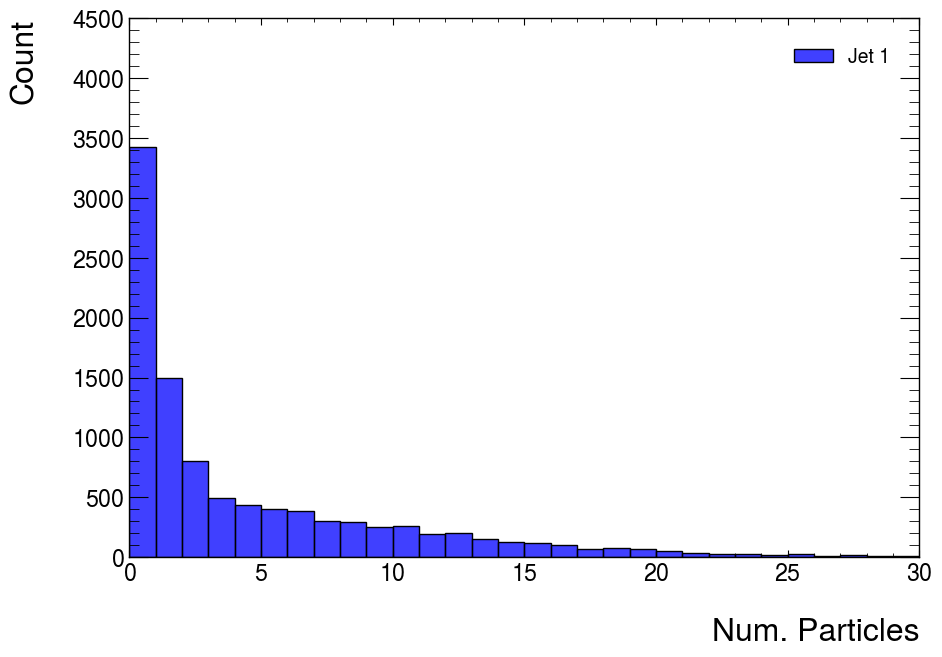

In [12]:
title = 'Total Number of Truth Matched BSM Particles to Jet 1: truthBSM vs pflow_reco' 
xlabel = 'Num. Particles'
atlas_plotter(num_deltaR_lt_1, xlabel, legend = 'Jet 1', binwidth = 1, xlim = (0, 30), ylim = (0, 4.5e3))

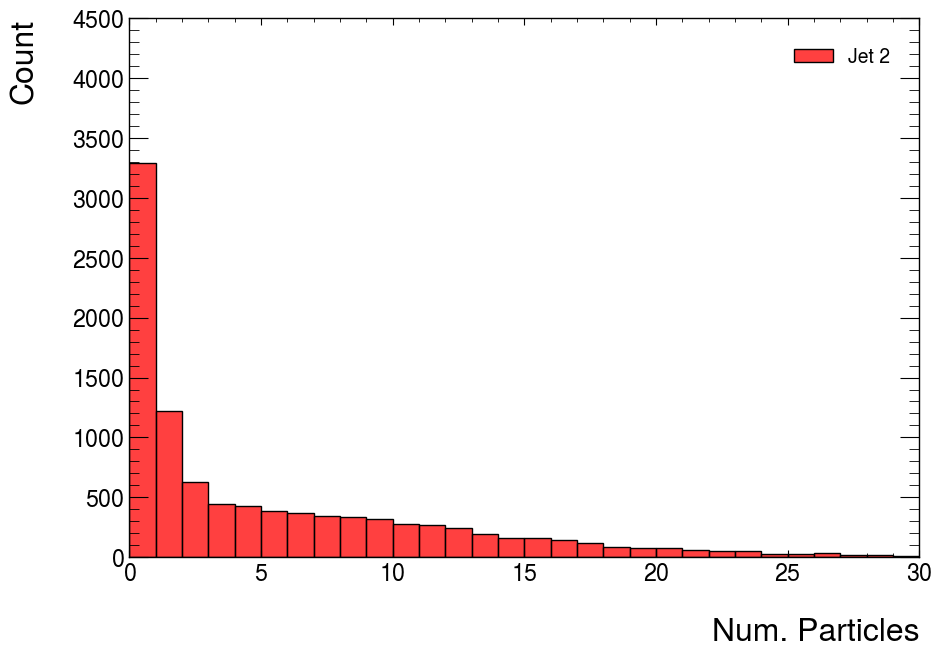

In [13]:
title = 'Total Number of Truth Matched BSM Particles to Jet 2: truthBSM vs pflow_reco' 
xlabel = 'Num. Particles'
atlas_plotter(num_deltaR_lt_2, xlabel, legend = 'Jet 2', binwidth = 1, color = 'red', xlim = (0, 30), ylim = (0, 4.5e3))

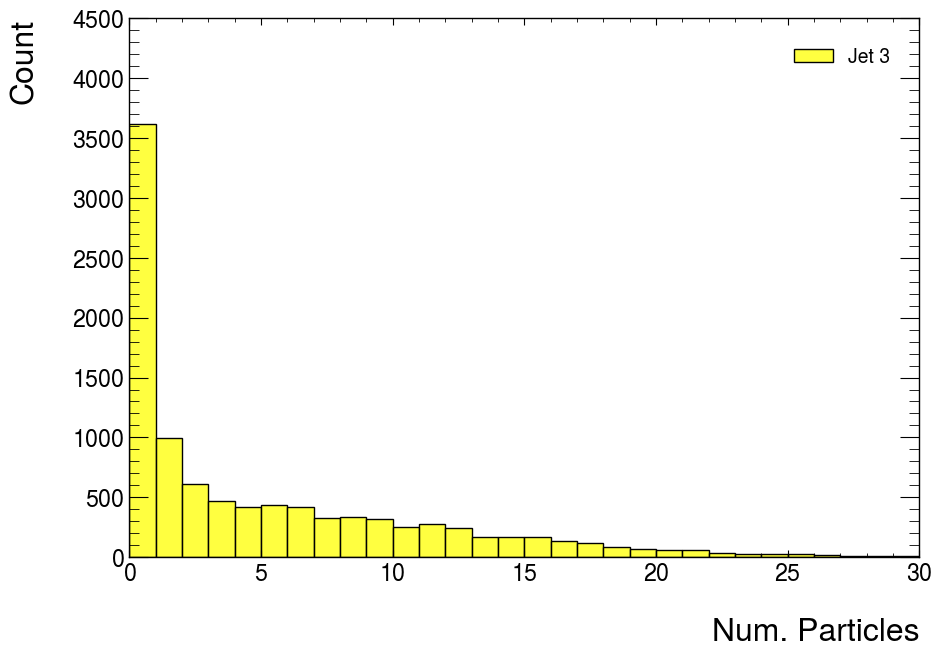

In [14]:
title = 'Total Number of Truth Matched BSM Particles to Jet 3: truthBSM vs pflow_reco' 
xlabel = 'Num. Particles'
atlas_plotter(num_deltaR_lt_3, xlabel, legend = 'Jet 3', binwidth = 1, color = 'yellow', xlim = (0, 30), ylim = (0, 4.5e3))

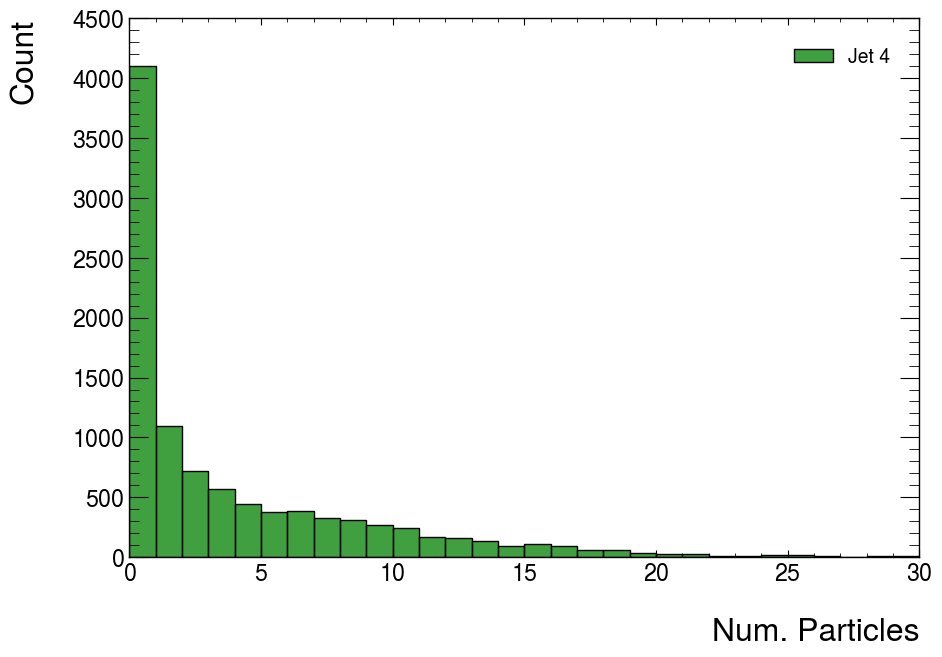

In [89]:
title = 'Total Number of Truth Matched BSM Particles to Jet 4: truthBSM vs pflow_reco' 
xlabel = 'Num. Particles'
atlas_plotter(num_deltaR_lt_4, xlabel, legend = 'Jet 4', binwidth = 1, color = 'green', xlim = (0, 30), ylim = (0, 4.5e3))

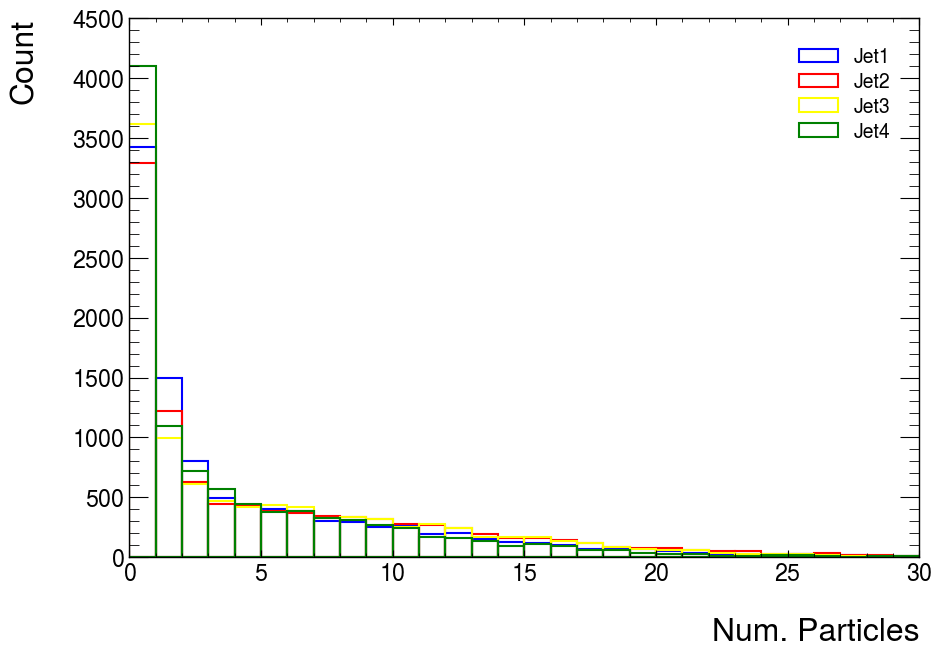

In [25]:
plt.figure(figsize = (10, 7))
plt.xlabel('Num. Particles')
plt.ylim(0, 4.5e3)
plt.xlim(0, 30)
sns.histplot(num_deltaR_lt_1, binwidth = 1, color = 'blue', label = 'Jet1', fill = False)
sns.histplot(num_deltaR_lt_2, binwidth = 1, color = 'red', label = 'Jet2', fill = False)
sns.histplot(num_deltaR_lt_3, binwidth = 1, color = 'yellow', label = 'Jet3', fill = False)
sns.histplot(num_deltaR_lt_4, binwidth = 1, color = 'green', label = 'Jet4', fill = False)
plt.legend()
plt.show()

We want to get a set of truth matched BSM particles to these jets. We want to get the ppdgid and store what jet this is found in

In [27]:
truthBSM_matched_jets_pdgid = []
for i in range(len(deltaR_lt_pos)):
    temp = []
    try:
        for j in deltaR_lt_pos[i]:
            if deltaR_lt_pos[i] != []:
                temp.append([j[0], truthBSM_pdgIDs[j[1], j[2]]])
            else:
                temp.append(-999)
    except:
        temp.append(-999)
        
    truthBSM_matched_jets_pdgid.append(temp)

We store the numbers of 4900101 in each jet in order to plot them

In [29]:
num_101_1 = []
num_101_2 = []
num_101_3 = []
num_101_4 = []
for i in truthBSM_matched_jets_pdgid:
    temp1 = 0
    temp2 = 0
    temp3 = 0
    temp4 = 0
    try:
        for j in i:
            if (j[1] == 4900101) or (j[1] == -4900101):
                if j[0] == 0:
                    temp1+=1
                elif j[0] == 1:
                    temp2+=1
                elif j[0] == 2:
                    temp3+=1
                elif j[0] == 3:
                    temp4+=1
        num_101_1.append(temp1)
        num_101_2.append(temp2)
        num_101_3.append(temp3)
        num_101_4.append(temp4)
    except:
        continue

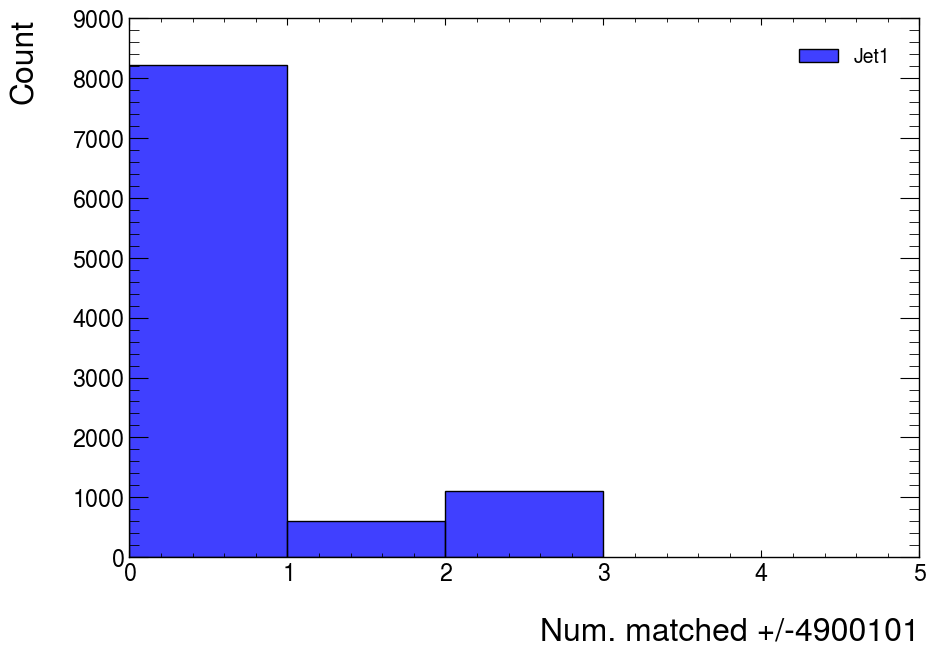

In [20]:
title = 'Total Number of Truth Matched +/-4900101 to Jet 1: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900101'
atlas_plotter(num_101_1, xlabel = xlabel, legend = 'Jet1', binwidth = 1, xlim = (0, 5), ylim = (0, 9e3))

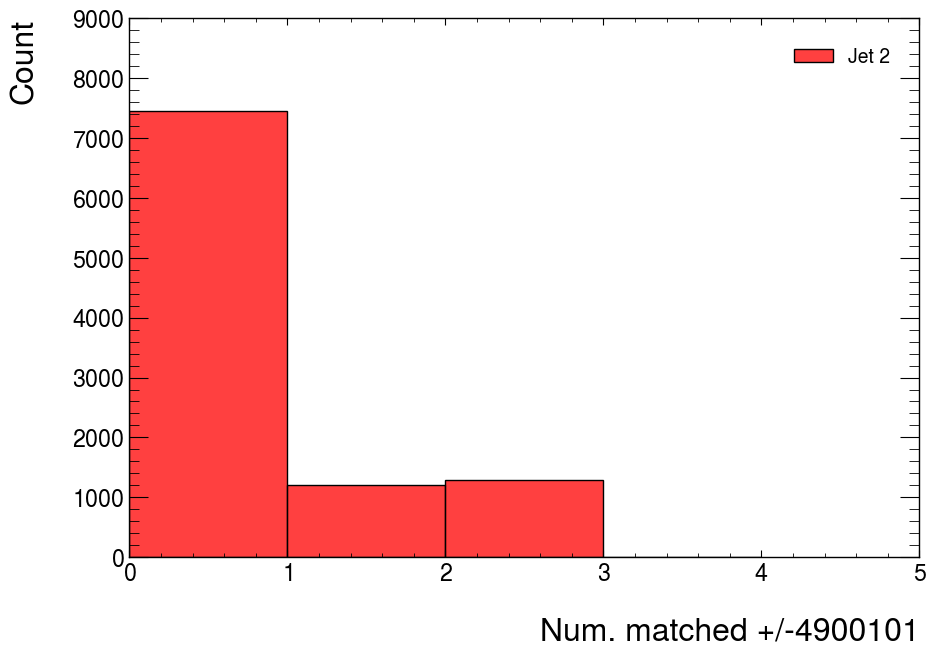

In [21]:
title = 'Total Number of Truth Matched +/-4900101 to Jet 2: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900101'
atlas_plotter(num_101_2, xlabel, legend = 'Jet 2', binwidth = 1, color = 'red', xlim = (0, 5), ylim = (0, 9e3))

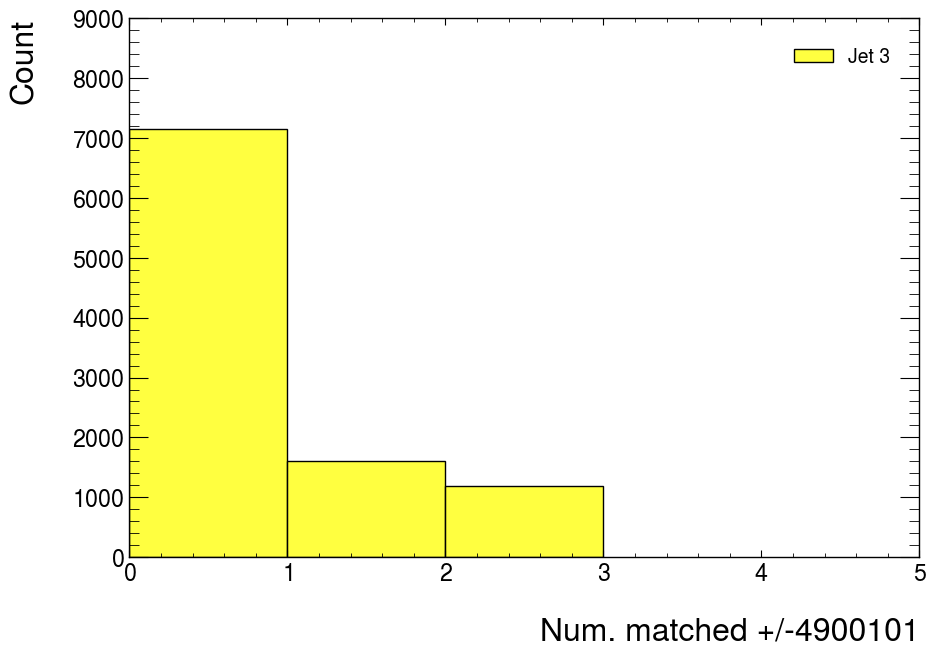

In [22]:
title = 'Total Number of Truth Matched +/-4900101 to Jet 3: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900101'
atlas_plotter(num_101_3, xlabel, legend = 'Jet 3', binwidth = 1, color = 'yellow', xlim = (0, 5), ylim = (0, 9e3))

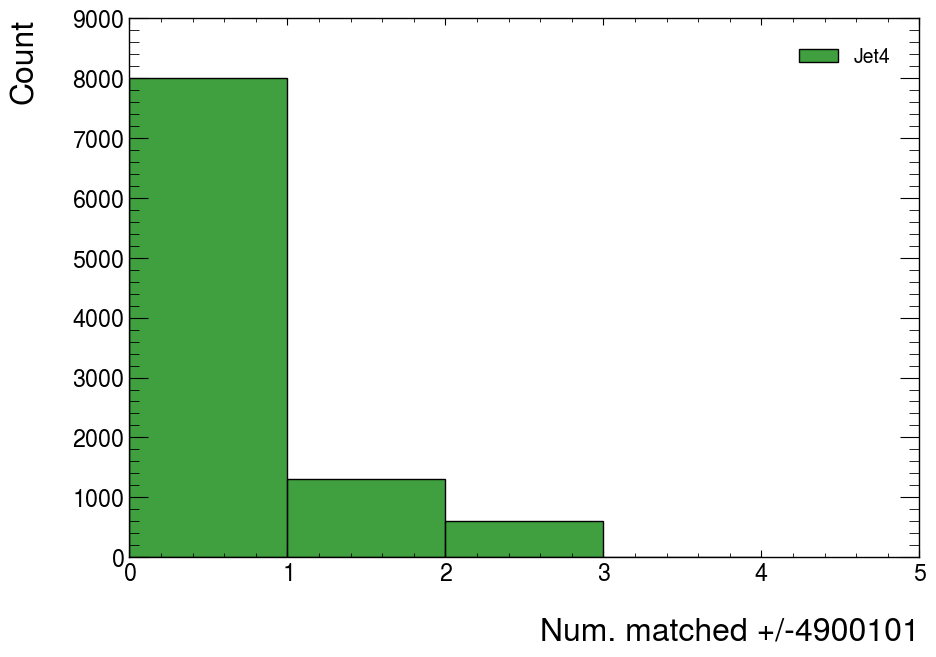

In [23]:
title = 'Total Number of Truth Matched +/-4900101 to Jet 4: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900101'
atlas_plotter(num_101_4, xlabel, legend = 'Jet4', binwidth = 1, color = 'green', xlim = (0, 5), ylim = (0, 9e3))

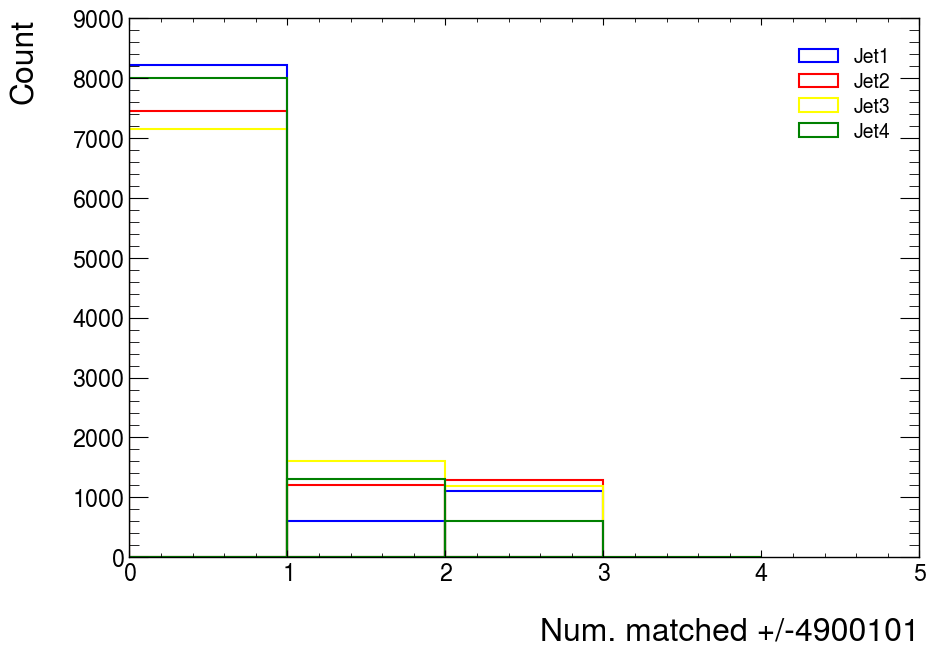

In [30]:
plt.figure(figsize = (10, 7))
plt.xlabel('Num. matched +/-4900101')
plt.ylim(0, 9e3)
plt.xlim(0, 5)
sns.histplot(num_101_1, binwidth = 1, color = 'blue', label = 'Jet1', fill = False)
sns.histplot(num_101_2, binwidth = 1, color = 'red', label = 'Jet2', fill = False)
sns.histplot(num_101_3, binwidth = 1, color = 'yellow', label = 'Jet3', fill = False)
sns.histplot(num_101_4, binwidth = 1, color = 'green', label = 'Jet4', fill = False)
plt.legend()
plt.show()

Repeat the above but with 4900021

In [31]:
num_021_1 = []
num_021_2 = []
num_021_3 = []
num_021_4 = []
for i in truthBSM_matched_jets_pdgid:
    temp1 = 0
    temp2 = 0
    temp3 = 0
    temp4 = 0
    try:
        for j in i:
            if (j[1] == 4900021) or (j[1] == -4900021):
                if j[0] == 0:
                    temp1+=1
                elif j[0] == 1:
                    temp2+=1
                elif j[0] == 2:
                    temp3+=1
                elif j[0] == 3:
                    temp4+=1
        num_021_1.append(temp1)
        num_021_2.append(temp2)
        num_021_3.append(temp3)
        num_021_4.append(temp4)
    except:
        continue

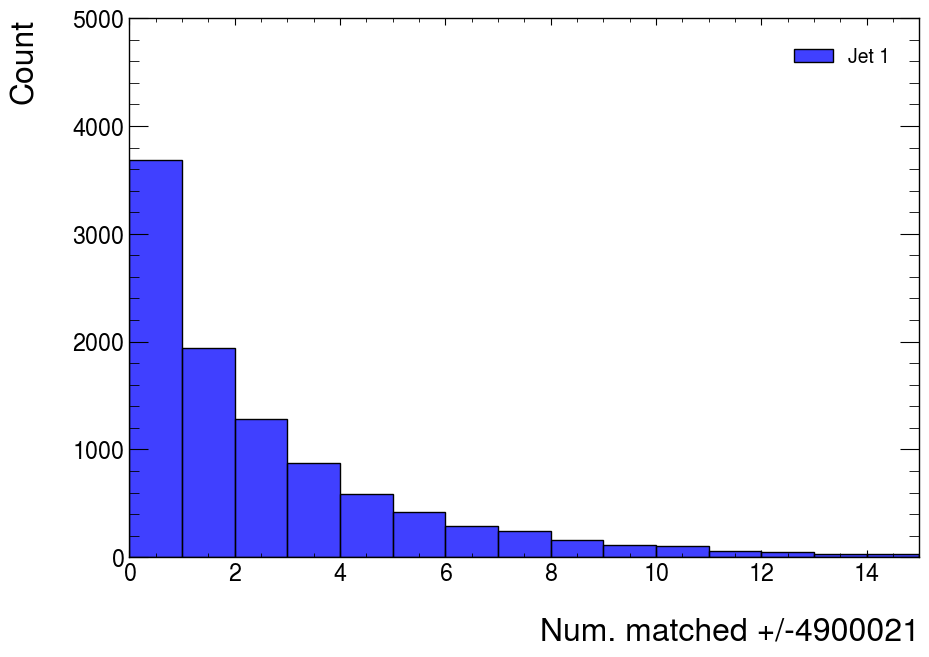

In [26]:
title = 'Total Number of Truth Matched +/-4900021 to Jet 1: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900021'
atlas_plotter(num_021_1, xlabel, legend = 'Jet 1', binwidth = 1, ylim = (0, 5e3), xlim = (0, 15))

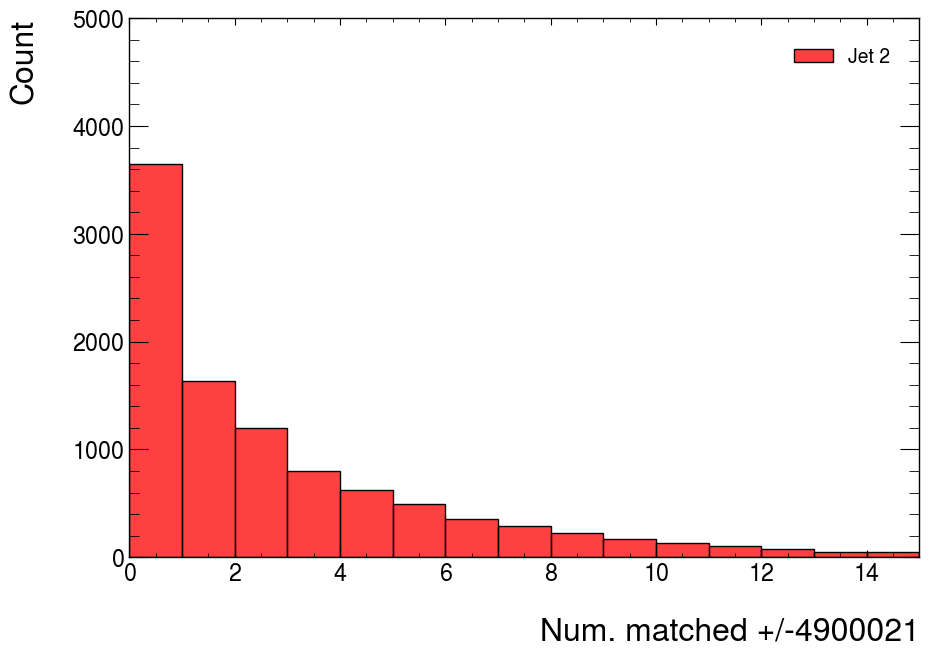

In [27]:
title = 'Total Number of Truth Matched +/-4900021 to Jet 2: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900021'
atlas_plotter(num_021_2, xlabel, legend = 'Jet 2', binwidth = 1, color = 'red', ylim = (0, 5e3), xlim = (0, 15))

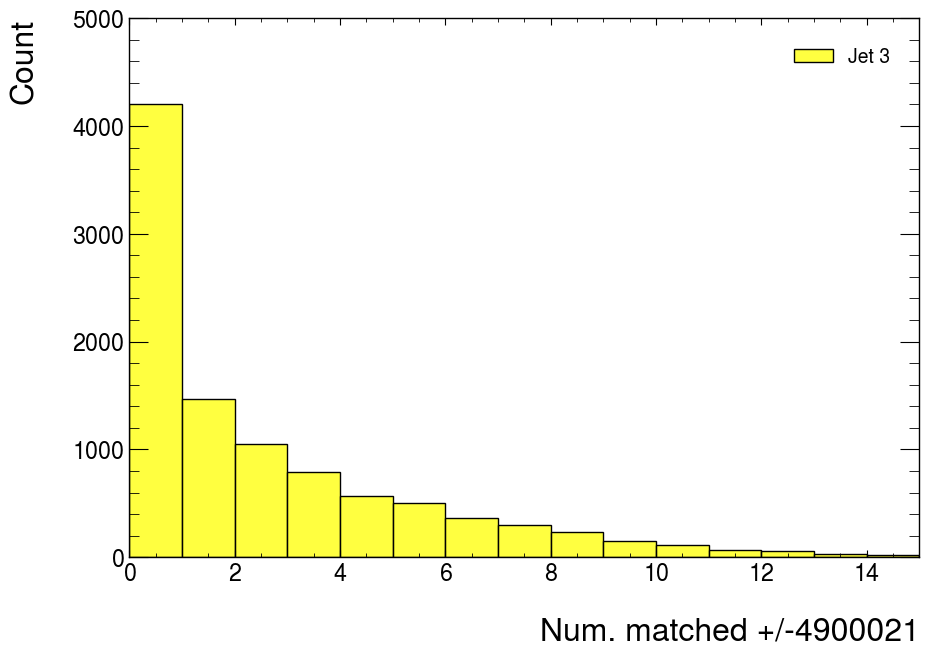

In [28]:
title = 'Total Number of Truth Matched +/-4900021 to Jet 3: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900021'
atlas_plotter(num_021_3, xlabel, legend = 'Jet 3', binwidth = 1, color = 'yellow', ylim = (0, 5e3), xlim = (0, 15))

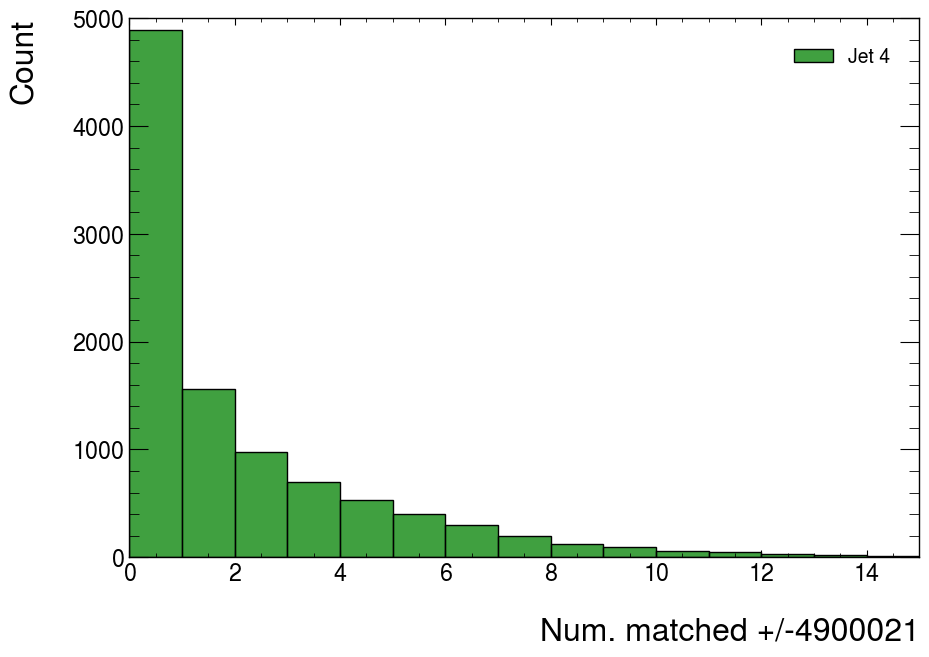

In [29]:
title = 'Total Number of Truth Matched +/-4900021 to Jet 4: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900021'
atlas_plotter(num_021_4, xlabel, legend = 'Jet 4', binwidth = 1, color = 'green', ylim = (0, 5e3), xlim = (0, 15))

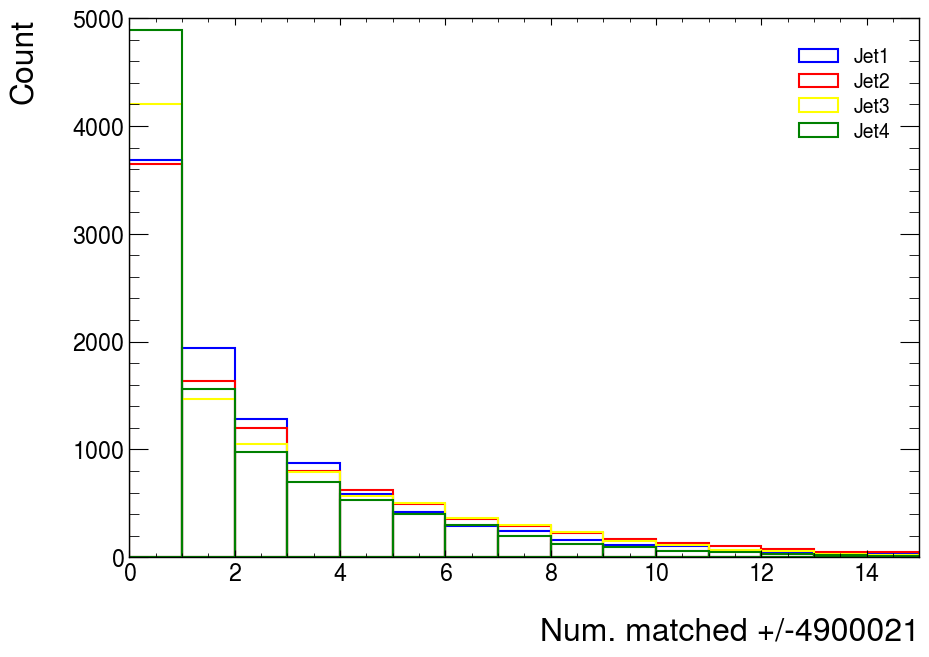

In [32]:
plt.figure(figsize = (10, 7))
plt.xlabel('Num. matched +/-4900021')
plt.ylim(0, 5e3)
plt.xlim(0, 15)
sns.histplot(num_021_1, binwidth = 1, color = 'blue', label = 'Jet1', fill = False)
sns.histplot(num_021_2, binwidth = 1, color = 'red', label = 'Jet2', fill = False)
sns.histplot(num_021_3, binwidth = 1, color = 'yellow', label = 'Jet3', fill = False)
sns.histplot(num_021_4, binwidth = 1, color = 'green', label = 'Jet4', fill = False)
plt.legend()
plt.show()

## How many jets are matched to?
We now move on to getting an idea of how many times we have 1 jet matched to at least 1 BSM particle, at least 2 jets matched to at least 1 particle each, and then the break down of which jets they are matching to. 

In [30]:
import pandas as pd

We are going to begin by just getting the jets where we have at least 1 matched to 1 and store a 1 or 0 based on whether the condition is met. Then we can look to see the number of times we have just 1 matched to 1, and 2 matched to at least 1 each

In [31]:
match_1to1 = []
for i in deltaR_lt_pos:
    if len(i) != 0:
        match_1to1.append(1)
    else:
        match_1to1.append(0)

In [32]:
match_2to1each = []
num = 0
for evt in deltaR_lt_pos:
    temp = 0
    temp2 = []
    try:
        for obj in evt:
            temp2.append(obj[0])
        count = Counter(temp2)
        if len(count.keys()) >= 2:
            temp = 1
        else:
            temp = 0
        match_2to1each.append(temp)
    except:
        match_2to1each.append(-999)

In [33]:
match_1to1_true = 0
match_2to1each_true = 0
for i in range(len(match_1to1)):
    if match_1to1[i] == 1:
        match_1to1_true+=1
    if match_2to1each[i] == 1:
        match_2to1each_true+=1

We want to get a percentage of those truth matched conditions in relation to the overall number of particles matched

In [34]:
percent_1to1 = round(match_1to1_true/len(match_1to1), 4) * 100

In [35]:
percent_2to1 = round(match_2to1each_true/len(match_2to1each), 4) * 100

Now we want to find out which of these jets specifically those truth matched particles are matched to in the 'at least 2 jets matched to at least 1 each' case. <br />
'XnY' refers to the jets that the matches happen to ie 1n2 -> jets 1 (a)n(d) 2. <br />
We are following essentially the same process as the previous, except with some extra conditional logic that splits down into different jet combinations

In [37]:
match_2to1_1n2 = []
match_2to1_1n3 = []
match_2to1_1n4 = []
match_2to1_2n3 = []
match_2to1_2n4 = []
match_2to1_3n4 = []
for evt in deltaR_lt_pos:
    temp12 = 0
    temp13 = 0
    temp14 = 0
    temp23 = 0
    temp24 = 0
    temp34 = 0
    objs = []
    try:
        for obj in evt:
            objs.append(obj[0])
        count = Counter(objs)
        if len(count.keys()) >=2:
            if (0 in count.keys()) and (1 in count.keys()):
                temp12=1
            if (0 in count.keys()) and (2 in count.keys()):
                temp13=1
            if (0 in count.keys()) and (3 in count.keys()):
                temp14=1
            if (1 in count.keys()) and (2 in count.keys()):
                temp23=1
            if (1 in count.keys()) and (3 in count.keys()):
                temp24=1
            if (2 in count.keys()) and (3 in count.keys()):
                temp34=1
        match_2to1_1n2.append(temp12)
        match_2to1_1n3.append(temp13)
        match_2to1_1n4.append(temp14)
        match_2to1_2n3.append(temp23)
        match_2to1_2n4.append(temp24)
        match_2to1_3n4.append(temp34)
    except: 
        match_2to1_1n2.append(0)
        match_2to1_1n3.append(0)
        match_2to1_1n4.append(0)
        match_2to1_2n3.append(0)
        match_2to1_2n4.append(0)
        match_2to1_3n4.append(0)

In [38]:
match_2to1_1n2_true = 0
match_2to1_1n3_true = 0
match_2to1_1n4_true = 0
match_2to1_2n3_true = 0
match_2to1_2n4_true = 0
match_2to1_3n4_true = 0
for i in range(len(match_2to1_1n2)):
    if match_2to1_1n2[i] == 1:
        match_2to1_1n2_true+=1
    if match_2to1_1n3[i] == 1:
        match_2to1_1n3_true+=1
    if match_2to1_1n4[i] == 1:
        match_2to1_1n4_true+=1
    if match_2to1_2n3[i] == 1:
        match_2to1_2n3_true+=1
    if match_2to1_2n4[i] == 1:
        match_2to1_2n4_true+=1
    if match_2to1_3n4[i] == 1:
        match_2to1_3n4_true+=1

In [39]:
percent_2to1_1n2 = round(match_2to1_1n2_true/len(match_2to1_1n2), 4) * 100
percent_2to1_1n3 = round(match_2to1_1n3_true/len(match_2to1_1n3), 4) * 100
percent_2to1_1n4 = round(match_2to1_1n4_true/len(match_2to1_1n4), 4) * 100
percent_2to1_2n3 = round(match_2to1_2n3_true/len(match_2to1_2n3), 4) * 100
percent_2to1_2n4 = round(match_2to1_2n4_true/len(match_2to1_2n4), 4) * 100
percent_2to1_3n4 = round(match_2to1_3n4_true/len(match_2to1_3n4), 4) * 100

In [40]:
print(percent_2to1_1n2)
print(percent_2to1_1n3)
print(percent_2to1_1n4)
print(percent_2to1_2n3)
print(percent_2to1_2n4)
print(percent_2to1_3n4)

44.5
41.75
39.25
42.66
39.39
37.940000000000005


In [41]:
data = [['Jets (A4)', 1,          2,                3,                4      ], 
        [1,           0, percent_2to1_1n2, percent_2to1_1n3, percent_2to1_1n4], 
        [2,           0,          0,       percent_2to1_2n3, percent_2to1_2n4], 
        [3,           0,          0,                0,       percent_2to1_3n4], 
        [4,           0,          0,                0,                0      ]]

The visualization here allows us to view the percentages at a glance. Notice that we have A4 which refers to the AntiKt4 jets. The AntiKt10 come later

In [42]:
df = pd.DataFrame(columns = data[0], data=data[1:])
df.style.hide_index()

Jets (A4),1,2,3,4
1,0,44.5,41.75,39.25
2,0,0,42.66,39.39
3,0,0,0,37.94
4,0,0,0,0


Now we move on to the specific particle versions, starting with 4900101

In [43]:
match_2to1_1n2_101 = []
match_2to1_1n3_101 = []
match_2to1_1n4_101 = []
match_2to1_2n3_101 = []
match_2to1_2n4_101 = []
match_2to1_3n4_101 = []
for i in range(len(deltaR_lt_pos)):
    temp12 = 0
    temp13 = 0
    temp14 = 0
    temp23 = 0
    temp24 = 0
    temp34 = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] == 4900101) or (particles[k] == -4900101):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            if (0 in count.keys()) and (1 in count.keys()):
                temp12=1
            if (0 in count.keys()) and (2 in count.keys()):
                temp13=1
            if (0 in count.keys()) and (3 in count.keys()):
                temp14=1
            if (1 in count.keys()) and (2 in count.keys()):
                temp23=1
            if (1 in count.keys()) and (3 in count.keys()):
                temp24=1
            if (2 in count.keys()) and (3 in count.keys()):
                temp34=1
        match_2to1_1n2_101.append(temp12)
        match_2to1_1n3_101.append(temp13)
        match_2to1_1n4_101.append(temp14)
        match_2to1_2n3_101.append(temp23)
        match_2to1_2n4_101.append(temp24)
        match_2to1_3n4_101.append(temp34)
    except: 
        match_2to1_1n2_101.append(0)
        match_2to1_1n3_101.append(0)
        match_2to1_1n4_101.append(0)
        match_2to1_2n3_101.append(0)
        match_2to1_2n4_101.append(0)
        match_2to1_3n4_101.append(0)

In [44]:
match_2to1_1n2_101_true = 0
match_2to1_1n3_101_true = 0
match_2to1_1n4_101_true = 0
match_2to1_2n3_101_true = 0
match_2to1_2n4_101_true = 0
match_2to1_3n4_101_true = 0
for i in range(len(match_2to1_1n2_101)):
    if match_2to1_1n2_101[i] == 1:
        match_2to1_1n2_101_true+=1
    if match_2to1_1n3_101[i] == 1:
        match_2to1_1n3_101_true+=1
    if match_2to1_1n4_101[i] == 1:
        match_2to1_1n4_101_true+=1
    if match_2to1_2n3_101[i] == 1:
        match_2to1_2n3_101_true+=1
    if match_2to1_2n4_101[i] == 1:
        match_2to1_2n4_101_true+=1
    if match_2to1_3n4_101[i] == 1:
        match_2to1_3n4_101_true+=1

In [45]:
match_1to1_101 = []
for i in range(len(deltaR_lt_pos)):
    temp1 = 0
    try:
        for j in range(len(deltaR_lt_pos[i])):
            if (truthBSM_matched_jets_pdgid[i][j][1] == 4900101) or (truthBSM_matched_jets_pdgid[i][j][1] == -4900101):
                temp1 = 1
        match_1to1_101.append(temp1)
    except:
        match_1to1_101.append(0)

In [46]:
match_1to1_101_true = 0
for i in range(len(match_1to1_101)):
    if match_1to1_101[i] == 1:
        match_1to1_101_true+=1

In [48]:
percent_1to1_101 = round(match_1to1_101_true/len(match_1to1_101), 4) * 100

In [50]:
match_2to1_101 = [] 
for i in range(len(deltaR_lt_pos)):
    temp = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] == 4900101) or (particles[k] == -4900101):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            temp = 1
        match_2to1_101.append(temp)
    except: 
        match_2to1_101.append(0)

In [51]:
match_2to1_101_true = 0
for i in range(len(match_2to1_101)):
    if match_2to1_101[i] == 1:
        match_2to1_101_true+=1

In [52]:
percent_2to1_101 = round(match_2to1_101_true/len(match_2to1_101), 4) * 100

In [54]:
percent_2to1_1n2_101 = round(match_2to1_1n2_101_true/len(match_2to1_1n2_101), 4) * 100
percent_2to1_1n3_101 = round(match_2to1_1n3_101_true/len(match_2to1_1n3_101), 4) * 100
percent_2to1_1n4_101 = round(match_2to1_1n4_101_true/len(match_2to1_1n4_101), 4) * 100
percent_2to1_2n3_101 = round(match_2to1_2n3_101_true/len(match_2to1_2n3_101), 4) * 100
percent_2to1_2n4_101 = round(match_2to1_2n4_101_true/len(match_2to1_2n4_101), 4) * 100
percent_2to1_3n4_101 = round(match_2to1_3n4_101_true/len(match_2to1_3n4_101), 4) * 100

In [55]:
print(percent_2to1_1n2_101)
print(percent_2to1_1n3_101)
print(percent_2to1_1n4_101)
print(percent_2to1_2n3_101)
print(percent_2to1_2n4_101)
print(percent_2to1_3n4_101)

2.4299999999999997
2.48
2.31
3.6700000000000004
3.6900000000000004
4.3999999999999995


In [56]:
data = [['Jets (A4 101)', 1,          2,                3,                4      ], 
        [1,           0, percent_2to1_1n2_101, percent_2to1_1n3_101, percent_2to1_1n4_101], 
        [2,           0,          0,       percent_2to1_2n3_101, percent_2to1_2n4_101], 
        [3,           0,          0,                0,       percent_2to1_3n4_101], 
        [4,           0,          0,                0,                0      ]]

In [57]:
df = pd.DataFrame(columns = data[0], data=data[1:])
df.style.hide_index()

Jets (A4 101),1,2,3,4
1,0,2.43,2.48,2.31
2,0,0,3.67,3.69
3,0,0,0,4.4
4,0,0,0,0


In [58]:
df_dict = {'Num. events with at least 1 jet matched to at least 1 particle' : match_1to1_true, 
           'Percentage of 1 jet matched to at least 1 particle' : percent_1to1, 
           'Num. events with at least 1 +/-4900101 particle matched to at least 1 jet': match_1to1_101_true,
           'Percentage of 1 jet matched to at least 1 +/-4900101 particle' : percent_1to1_101,
           'Num. events with at least 2 jets matched to at least 1 particle each' : match_2to1each_true, 
           'Percentage of 2 jets matched to at least 1 particle each' : percent_2to1, 
           'Num. events with at least 2 +/-4900101 particles matched to 2 different jets' : match_2to1_101_true,
           'Percentage of 2 jets matched to at least 1 +/-4900101 particle each' : percent_2to1_101}

In [59]:
columns = ['Description', 'Num. Events', 'Percentage']
descriptions = ['At least 1 jet matched to at least 1 BSM', 
                'At least 1 jet matched to at least 1 +/-4900101 particle each', 
                'At least 2 jets matched to at least 1 particle each', 
                'At least 2 jets matched to at least 1 +/-4900101 particle each']

In [60]:
data = np.array(list(df_dict.values())).reshape((-1, 2))

In [61]:
df = pd.DataFrame(data, columns = columns[1:])

In [62]:
df.insert(loc = 0, column = columns[0], value = descriptions)

This finally gives us a bit more of a description of the data than the simpler percentages will.

In [63]:
df.style.hide_index()

Description,Num. Events,Percentage
At least 1 jet matched to at least 1 BSM,9731,97.78
At least 1 jet matched to at least 1 +/-4900101 particle each,7055,70.89
At least 2 jets matched to at least 1 particle each,8476,85.17
At least 2 jets matched to at least 1 +/-4900101 particle each,1859,18.68


Same as before but with 4900021

In [64]:
match_2to1_1n2_21 = []
match_2to1_1n3_21 = []
match_2to1_1n4_21 = []
match_2to1_2n3_21 = []
match_2to1_2n4_21 = []
match_2to1_3n4_21 = []
for i in range(len(deltaR_lt_pos)):
    temp12 = 0
    temp13 = 0
    temp14 = 0
    temp23 = 0
    temp24 = 0
    temp34 = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] == 4900021) or (particles[k] == -4900021):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            if (0 in count.keys()) and (1 in count.keys()):
                temp12=1
            if (0 in count.keys()) and (2 in count.keys()):
                temp13=1
            if (0 in count.keys()) and (3 in count.keys()):
                temp14=1
            if (1 in count.keys()) and (2 in count.keys()):
                temp23=1
            if (1 in count.keys()) and (3 in count.keys()):
                temp24=1
            if (2 in count.keys()) and (3 in count.keys()):
                temp34=1
        match_2to1_1n2_21.append(temp12)
        match_2to1_1n3_21.append(temp13)
        match_2to1_1n4_21.append(temp14)
        match_2to1_2n3_21.append(temp23)
        match_2to1_2n4_21.append(temp24)
        match_2to1_3n4_21.append(temp34)
    except: 
        match_2to1_1n2_21.append(0)
        match_2to1_1n3_21.append(0)
        match_2to1_1n4_21.append(0)
        match_2to1_2n3_21.append(0)
        match_2to1_2n4_21.append(0)
        match_2to1_3n4_21.append(0)

In [65]:
match_2to1_1n2_21_true = 0
match_2to1_1n3_21_true = 0
match_2to1_1n4_21_true = 0
match_2to1_2n3_21_true = 0
match_2to1_2n4_21_true = 0
match_2to1_3n4_21_true = 0
for i in range(len(match_2to1_1n2_21)):
    if match_2to1_1n2_21[i] == 1:
        match_2to1_1n2_21_true+=1
    if match_2to1_1n3_21[i] == 1:
        match_2to1_1n3_21_true+=1
    if match_2to1_1n4_21[i] == 1:
        match_2to1_1n4_21_true+=1
    if match_2to1_2n3_21[i] == 1:
        match_2to1_2n3_21_true+=1
    if match_2to1_2n4_21[i] == 1:
        match_2to1_2n4_21_true+=1
    if match_2to1_3n4_21[i] == 1:
        match_2to1_3n4_21_true+=1

In [66]:
match_1to1_21 = []
for i in range(len(deltaR_lt_pos)):
    temp1 = 0
    try:
        for j in range(len(deltaR_lt_pos[i])):
            if (truthBSM_matched_jets_pdgid[i][j][1] == 4900021) or (truthBSM_matched_jets_pdgid[i][j][1] == -4900021):
                temp1 = 1
        match_1to1_21.append(temp1)
    except:
        match_1to1_21.append(0)

In [67]:
match_1to1_21_true = 0
for i in range(len(match_1to1_21)):
    if match_1to1_21[i] == 1:
        match_1to1_21_true+=1

In [78]:
percent_1to1_21 = round(match_1to1_21_true/len(match_1to1_21), 4) * 100

In [69]:
match_2to1_21 = [] 
for i in range(len(deltaR_lt_pos)):
    temp = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] == 4900021) or (particles[k] == -4900021):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            temp = 1
        match_2to1_21.append(temp)
    except: 
        match_2to1_21.append(0)

In [70]:
match_2to1_21_true = 0
for i in range(len(match_2to1_21)):
    if match_2to1_21[i] == 1:
        match_2to1_21_true+=1

In [71]:
percent_2to1_21 = round(match_2to1_21_true/len(match_2to1_21), 4) * 100

In [73]:
percent_2to1_1n2_21 = round(match_2to1_1n2_21_true/len(match_2to1_1n2_21), 4) * 100
percent_2to1_1n3_21 = round(match_2to1_1n3_21_true/len(match_2to1_1n3_21), 4) * 100
percent_2to1_1n4_21 = round(match_2to1_1n4_21_true/len(match_2to1_1n4_21), 4) * 100
percent_2to1_2n3_21 = round(match_2to1_2n3_21_true/len(match_2to1_2n3_21), 4) * 100
percent_2to1_2n4_21 = round(match_2to1_2n4_21_true/len(match_2to1_2n4_21), 4) * 100
percent_2to1_3n4_21 = round(match_2to1_3n4_21_true/len(match_2to1_3n4_21), 4) * 100

In [74]:
print(percent_2to1_1n2_21)
print(percent_2to1_1n3_21)
print(percent_2to1_1n4_21)
print(percent_2to1_2n3_21)
print(percent_2to1_2n4_21)
print(percent_2to1_3n4_21)

40.82
36.51
33.1
36.74
32.47
29.99


In [75]:
data = [['Jets (A4 21)', 1,          2,                3,                4      ], 
        [1,           0, percent_2to1_1n2_21, percent_2to1_1n3_21, percent_2to1_1n4_21], 
        [2,           0,          0,       percent_2to1_2n3_21, percent_2to1_2n4_21], 
        [3,           0,          0,                0,       percent_2to1_3n4_21], 
        [4,           0,          0,                0,                0      ]]

In [76]:
df = pd.DataFrame(columns = data[0], data=data[1:])
df.style.hide_index()

Jets (A4 21),1,2,3,4
1,0,40.82,36.51,33.1
2,0,0,36.74,32.47
3,0,0,0,29.99
4,0,0,0,0


In [79]:
df_dict = {'Num. events with at least 1 jet matched to at least 1 particle' : match_1to1_true, 
           'Percentage of 1 jet matched to at least 1 particle' : percent_1to1, 
           'Num. events with at least 1 +/-4900021 particle matched to at least 1 jet': match_1to1_21_true,
           'Percentage of 1 jet matched to at least 1 +/-4900021 particle' : percent_1to1_21,
           'Num. events with at least 2 jets matched to at least 1 particle each' : match_2to1each_true, 
           'Percentage of 2 jets matched to at least 1 particle each' : percent_2to1, 
           'Num. events with at least 2 +/-4900021 particles matched to 2 different jets' : match_2to1_21_true,
           'Percentage of 2 jets matched to at least 1 +/-4900021 particle each' : percent_2to1_21}

In [80]:
columns = ['Description', 'Num. Events', 'Percentage']
descriptions = ['At least 1 jet matched to at least 1 BSM', 
                'At least 1 jet matched to at least 1 +/-4900021 particle each', 
                'At least 2 jets matched to at least 1 particle each', 
                'At least 2 jets matched to at least 1 +/-4900021 particle each']

In [81]:
data = np.array(list(df_dict.values())).reshape((-1, 2))

In [82]:
df = pd.DataFrame(data, columns = columns[1:])

In [83]:
df.insert(loc = 0, column = columns[0], value = descriptions)

In [84]:
df.style.hide_index()

Description,Num. Events,Percentage
At least 1 jet matched to at least 1 BSM,9731,97.78
At least 1 jet matched to at least 1 +/-4900021 particle each,9579,96.25
At least 2 jets matched to at least 1 particle each,8476,85.17
At least 2 jets matched to at least 1 +/-4900021 particle each,7901,79.39


## Reapeat with AntiKt10
Repeating this with AntiKt10 requires that a new set of variables are made by the matching function. This could be done using different variable names, but in the interest of ease I have not here

In [33]:
deltaR_lt, deltaR_lt_pos, num_deltaR_lt_1, num_deltaR_lt_2, num_deltaR_lt_3, num_deltaR_lt_4 = jet_match(tree, 'truthBSM', 'a10_lctopojets_raw', deltaR_lim = 0.5)

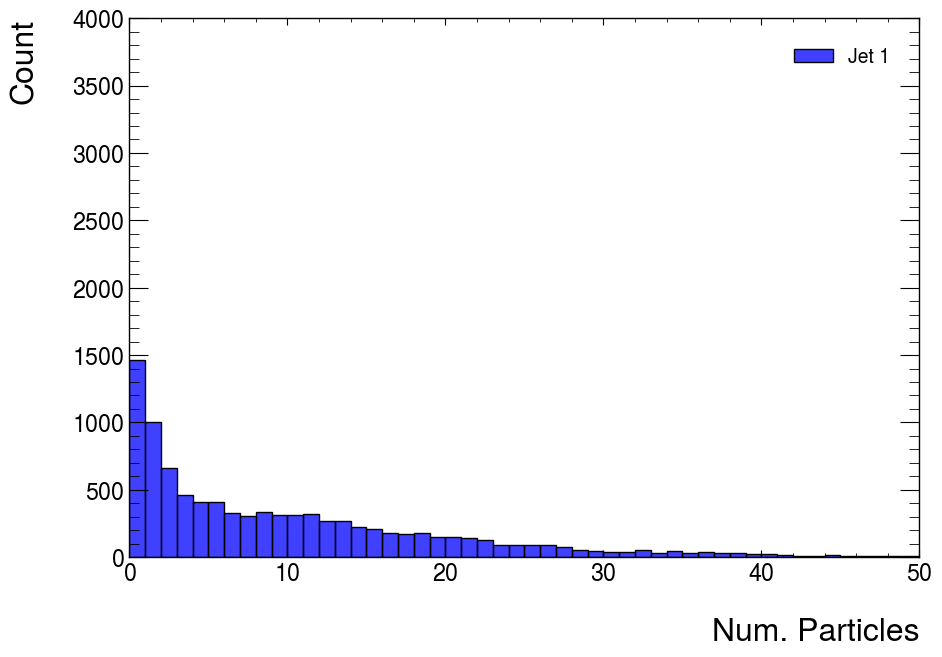

In [102]:
title = 'Total Number of Truth Matched BSM Particles to Jet 1: truthBSM vs pflow_reco' 
xlabel = 'Num. Particles'
atlas_plotter(num_deltaR_lt_1, xlabel, legend = 'Jet 1', binwidth = 1, xlim = (0, 50), ylim = (0, 4e3))

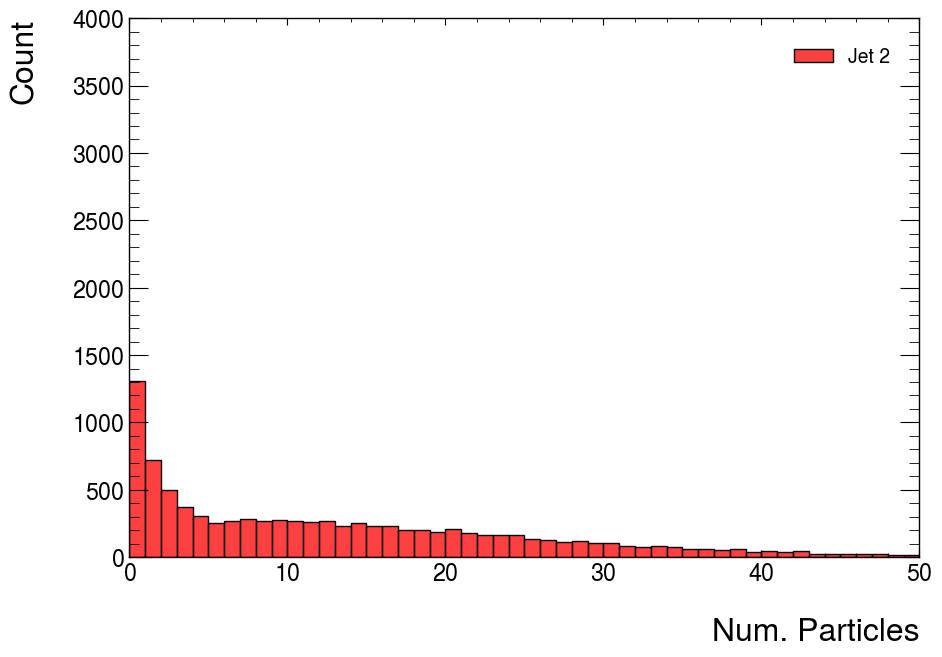

In [103]:
title = 'Total Number of Truth Matched BSM Particles to Jet 2: truthBSM vs pflow_reco' 
xlabel = 'Num. Particles'
atlas_plotter(num_deltaR_lt_2, xlabel, legend = 'Jet 2', binwidth = 1, color = 'red', xlim = (0, 50), ylim = (0, 4e3))

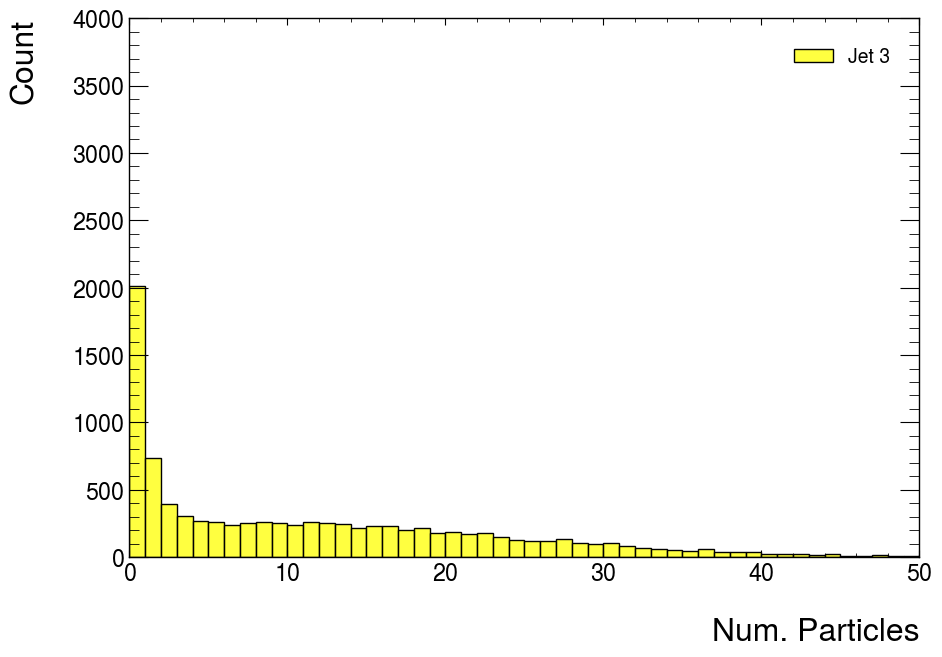

In [104]:
title = 'Total Number of Truth Matched BSM Particles to Jet 3: truthBSM vs pflow_reco' 
xlabel = 'Num. Particles'
atlas_plotter(num_deltaR_lt_3, xlabel, legend = 'Jet 3', binwidth = 1, color = 'yellow', xlim = (0, 50), ylim = (0, 4e3))

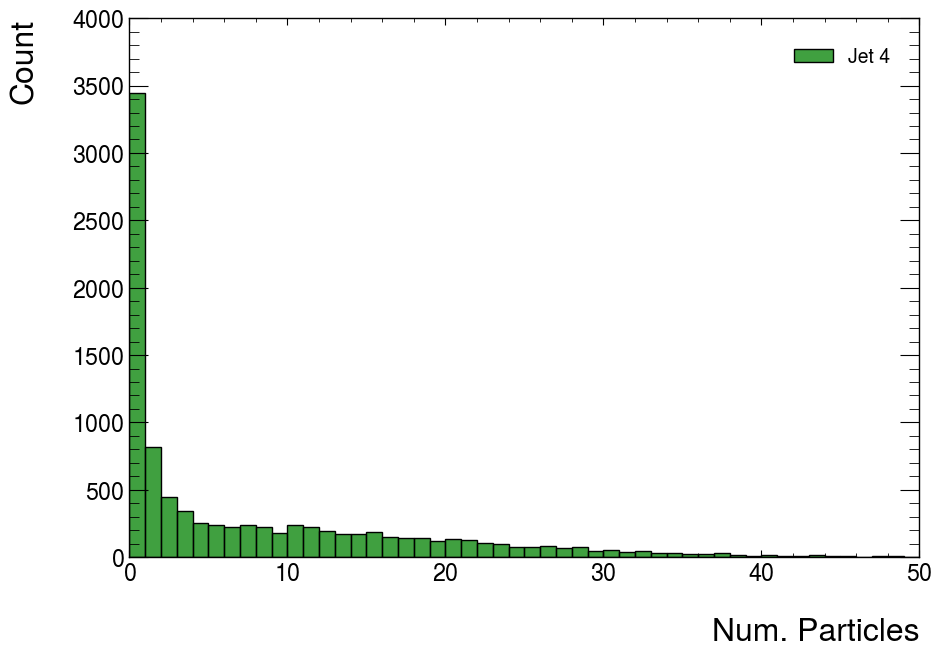

In [105]:
title = 'Total Number of Truth Matched BSM Particles to Jet 4: truthBSM vs pflow_reco' 
xlabel = 'Num. Particles'
atlas_plotter(num_deltaR_lt_4, xlabel, legend = 'Jet 4', binwidth = 1, color = 'green', xlim = (0, 50), ylim = (0, 4e3))

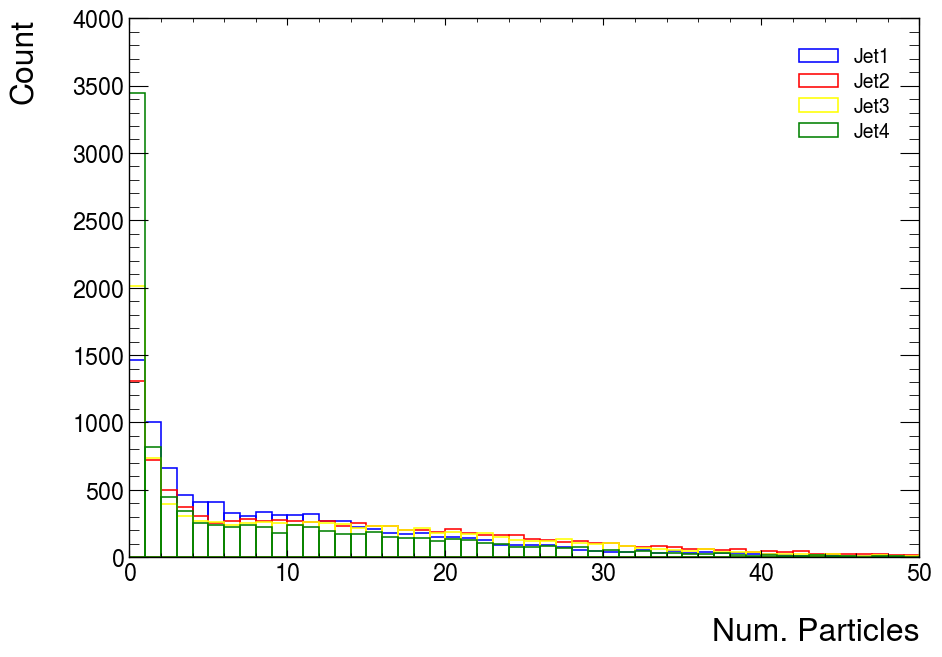

In [34]:
plt.figure(figsize = (10, 7))
plt.xlabel('Num. Particles')
plt.ylim(0, 4e3)
plt.xlim(0, 50)
sns.histplot(num_deltaR_lt_1, binwidth = 1, color = 'blue', label = 'Jet1', fill = False)
sns.histplot(num_deltaR_lt_2, binwidth = 1, color = 'red', label = 'Jet2', fill = False)
sns.histplot(num_deltaR_lt_3, binwidth = 1, color = 'yellow', label = 'Jet3', fill = False)
sns.histplot(num_deltaR_lt_4, binwidth = 1, color = 'green', label = 'Jet4', fill = False)
plt.legend()
plt.show()

In [35]:
truthBSM_matched_jets_pdgid = []
for i in range(len(deltaR_lt_pos)):
    temp = []
    try:
        for j in deltaR_lt_pos[i]:
            if deltaR_lt_pos[i] != []:
                temp.append([j[0], truthBSM_pdgIDs[j[1], j[2]]])
            else:
                temp.append(-999)
    except:
        temp.append(-999)
        
    truthBSM_matched_jets_pdgid.append(temp)

In [36]:
num_101_1 = []
num_101_2 = []
num_101_3 = []
num_101_4 = []
for i in truthBSM_matched_jets_pdgid:
    temp1 = 0
    temp2 = 0
    temp3 = 0
    temp4 = 0
    try:
        for j in i:
            if (j[1] == 4900101) or (j[1] == -4900101):
                if j[0] == 0:
                    temp1+=1
                elif j[0] == 1:
                    temp2+=1
                elif j[0] == 2:
                    temp3+=1
                elif j[0] == 3:
                    temp4+=1
        num_101_1.append(temp1)
        num_101_2.append(temp2)
        num_101_3.append(temp3)
        num_101_4.append(temp4)
    except:
        continue

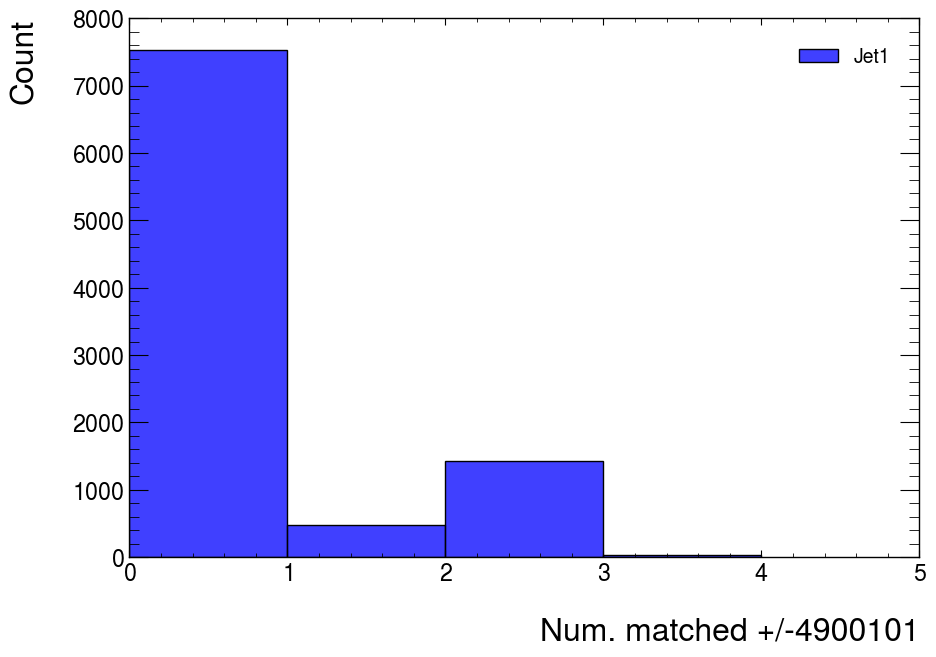

In [108]:
title = 'Total Number of Truth Matched +/-4900101 to Jet 1: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900101'
atlas_plotter(num_101_1, xlabel = xlabel, legend = 'Jet1', binwidth = 1, xlim = (0, 5), ylim = (0, 8e3))

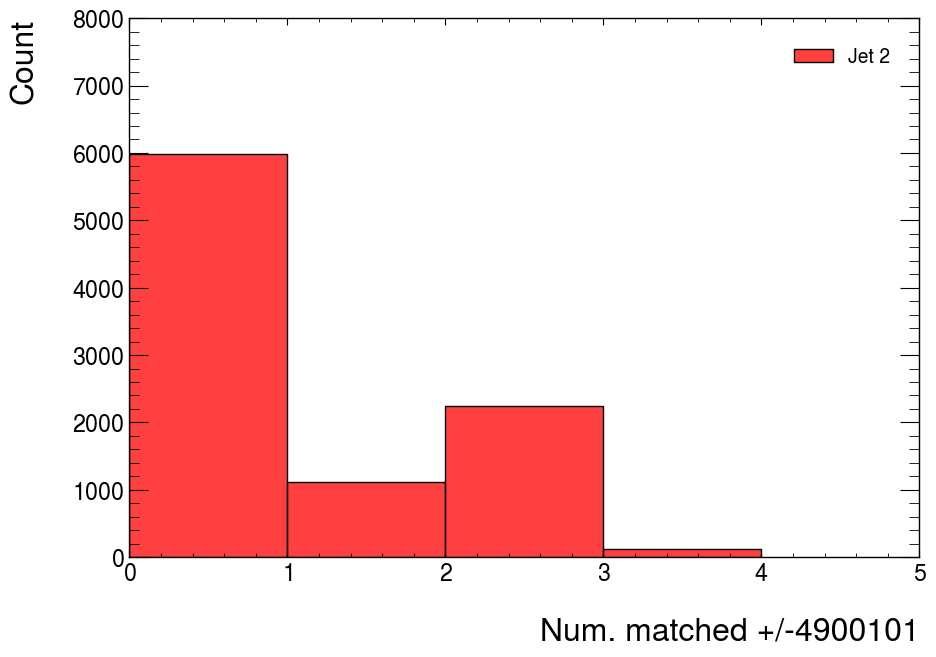

In [109]:
title = 'Total Number of Truth Matched +/-4900101 to Jet 2: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900101'
atlas_plotter(num_101_2, xlabel, legend = 'Jet 2', binwidth = 1, color = 'red', xlim = (0, 5), ylim = (0, 8e3))

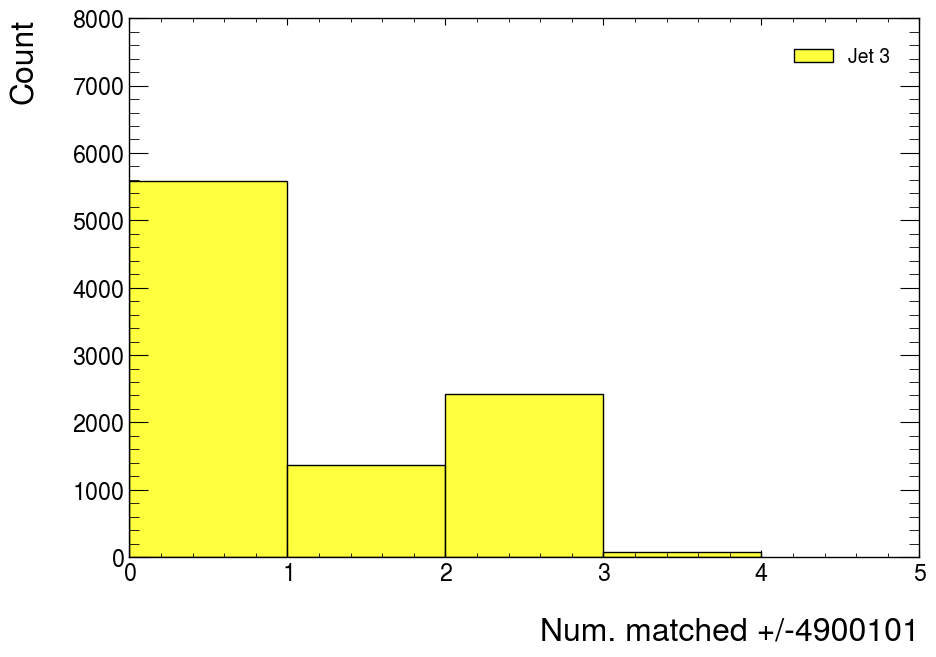

In [110]:
title = 'Total Number of Truth Matched +/-4900101 to Jet 3: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900101'
atlas_plotter(num_101_3, xlabel, legend = 'Jet 3', binwidth = 1, color = 'yellow', xlim = (0, 5), ylim = (0, 8e3))

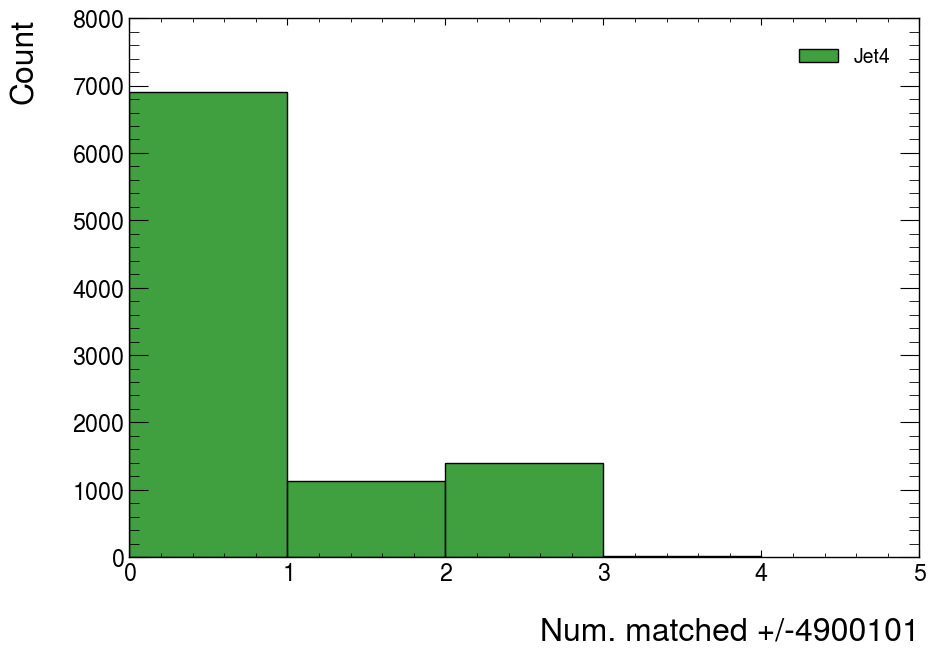

In [111]:
title = 'Total Number of Truth Matched +/-4900101 to Jet 4: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900101'
atlas_plotter(num_101_4, xlabel, legend = 'Jet4', binwidth = 1, color = 'green', xlim = (0, 5), ylim = (0, 8e3))

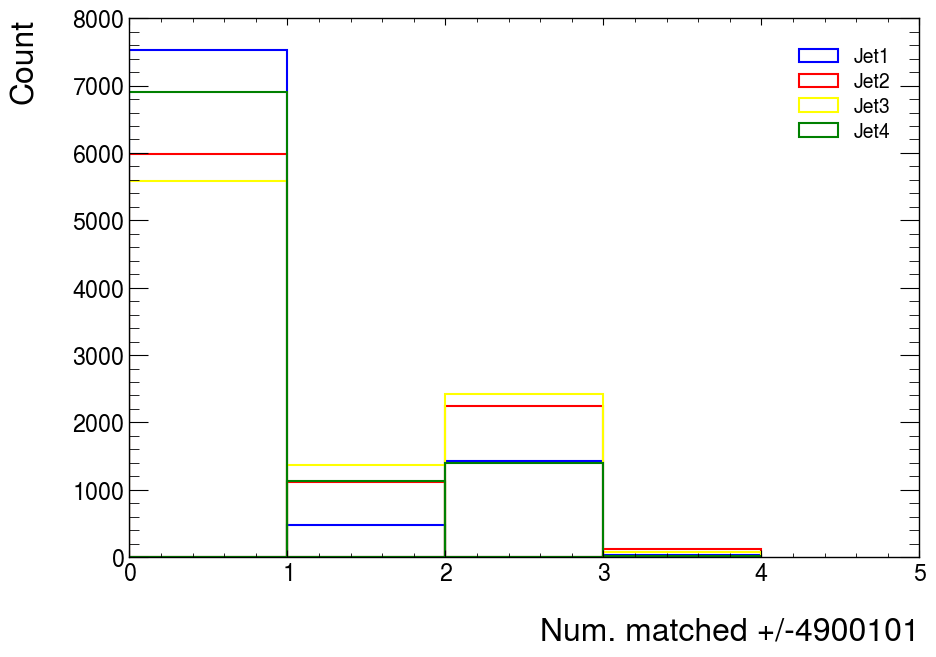

In [37]:
plt.figure(figsize = (10, 7))
plt.xlabel('Num. matched +/-4900101')
plt.ylim(0, 8e3)
plt.xlim(0, 5)
sns.histplot(num_101_1, binwidth = 1, color = 'blue', label = 'Jet1', fill = False)
sns.histplot(num_101_2, binwidth = 1, color = 'red', label = 'Jet2', fill = False)
sns.histplot(num_101_3, binwidth = 1, color = 'yellow', label = 'Jet3', fill = False)
sns.histplot(num_101_4, binwidth = 1, color = 'green', label = 'Jet4', fill = False)
plt.legend()
plt.show()

In [38]:
num_021_1 = []
num_021_2 = []
num_021_3 = []
num_021_4 = []
for i in truthBSM_matched_jets_pdgid:
    temp1 = 0
    temp2 = 0
    temp3 = 0
    temp4 = 0
    try:
        for j in i:
            if (j[1] == 4900021) or (j[1] == -4900021):
                if j[0] == 0:
                    temp1+=1
                elif j[0] == 1:
                    temp2+=1
                elif j[0] == 2:
                    temp3+=1
                elif j[0] == 3:
                    temp4+=1
        num_021_1.append(temp1)
        num_021_2.append(temp2)
        num_021_3.append(temp3)
        num_021_4.append(temp4)
    except:
        continue

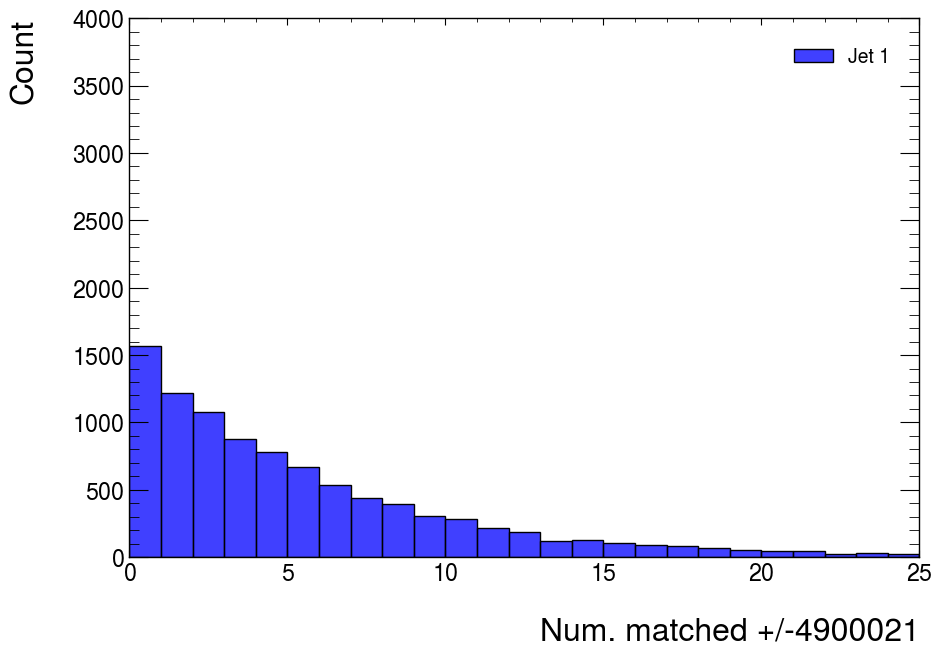

In [113]:
title = 'Total Number of Truth Matched +/-4900021 to Jet 1: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900021'
atlas_plotter(num_021_1, xlabel, legend = 'Jet 1', binwidth = 1, xlim = (0, 25), ylim = (0, 4e3))

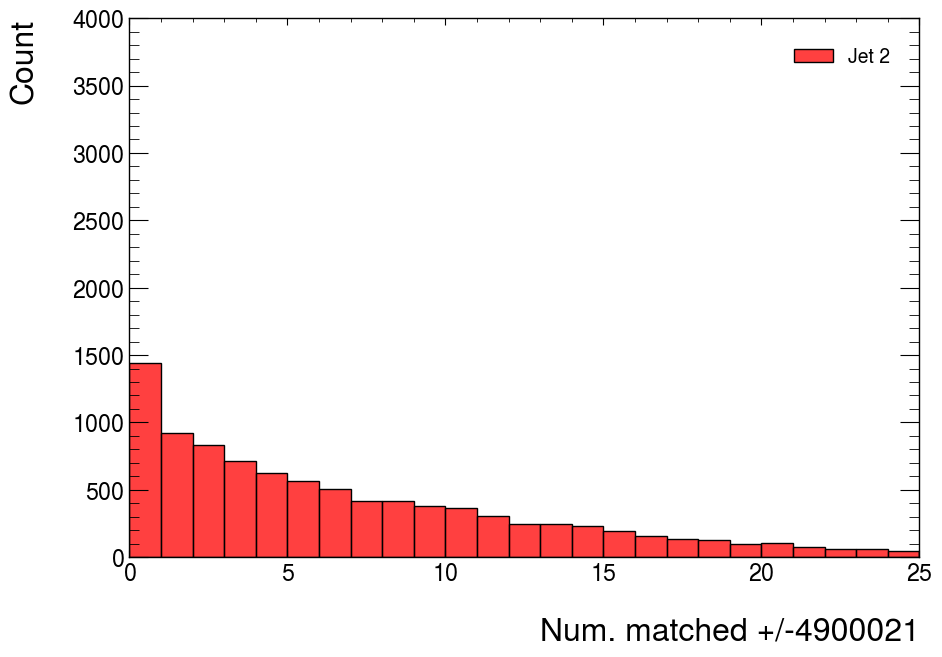

In [114]:
title = 'Total Number of Truth Matched +/-4900021 to Jet 2: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900021'
atlas_plotter(num_021_2, xlabel, legend = 'Jet 2', binwidth = 1, color = 'red', xlim = (0, 25), ylim = (0, 4e3))

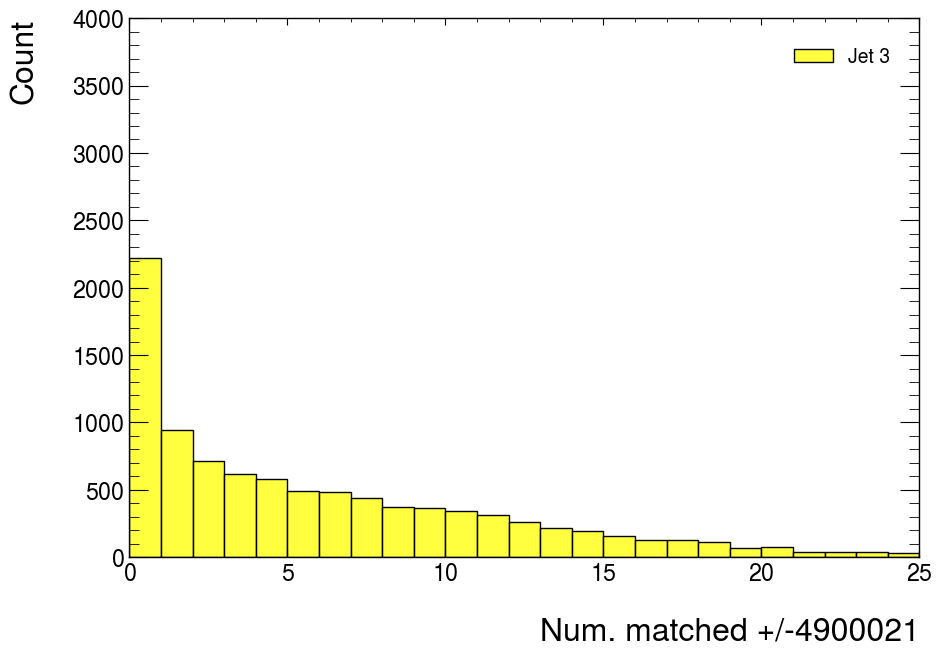

In [115]:
title = 'Total Number of Truth Matched +/-4900021 to Jet 3: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900021'
atlas_plotter(num_021_3, xlabel, legend = 'Jet 3', binwidth = 1, color = 'yellow', xlim = (0, 25), ylim = (0, 4e3))

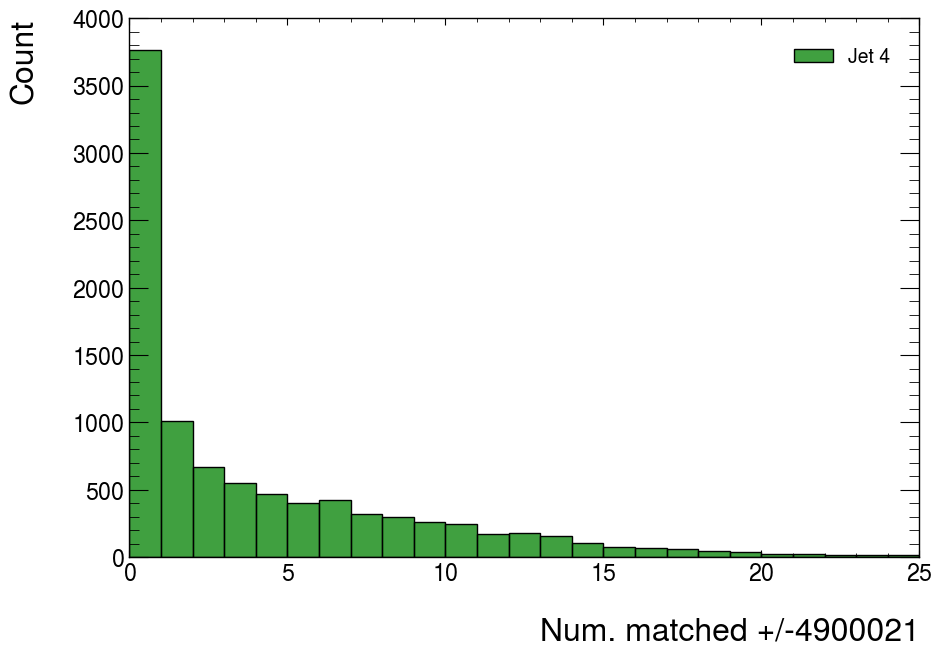

In [116]:
title = 'Total Number of Truth Matched +/-4900021 to Jet 4: truthBSM vs pflow_reco'
xlabel = 'Num. matched +/-4900021'
atlas_plotter(num_021_4, xlabel, legend = 'Jet 4', binwidth = 1, color = 'green', xlim = (0, 25), ylim = (0, 4e3))

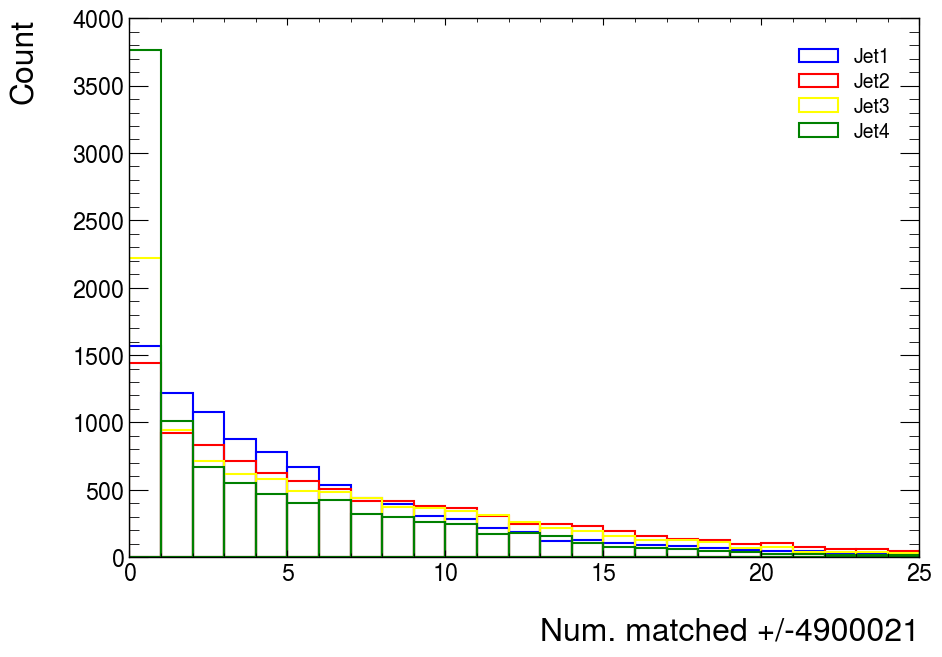

In [39]:
plt.figure(figsize = (10, 7))
plt.xlabel('Num. matched +/-4900021')
plt.ylim(0, 4e3)
plt.xlim(0, 25)
sns.histplot(num_021_1, binwidth = 1, color = 'blue', label = 'Jet1', fill = False)
sns.histplot(num_021_2, binwidth = 1, color = 'red', label = 'Jet2', fill = False)
sns.histplot(num_021_3, binwidth = 1, color = 'yellow', label = 'Jet3', fill = False)
sns.histplot(num_021_4, binwidth = 1, color = 'green', label = 'Jet4', fill = False)
plt.legend()
plt.show()

In [117]:
match_1to1 = []
for i in deltaR_lt_pos:
    if len(i) != 0:
        match_1to1.append(1)
    else:
        match_1to1.append(0)

In [118]:
match_2to1each = []
num = 0
for evt in deltaR_lt_pos:
    temp = 0
    temp2 = []
    try:
        for obj in evt:
            temp2.append(obj[0])
        count = Counter(temp2)
        if len(count.keys()) >= 2:
            temp = 1
        else:
            temp = 0
        match_2to1each.append(temp)
    except:
        match_2to1each.append(-999)

In [119]:
match_1to1_true = 0
match_2to1each_true = 0
for i in range(len(match_1to1)):
    if match_1to1[i] == 1:
        match_1to1_true+=1
    if match_2to1each[i] == 1:
        match_2to1each_true+=1

In [120]:
percent_1to1 = round(match_1to1_true/len(match_1to1), 4) * 100

In [121]:
percent_2to1 = round(match_2to1each_true/len(match_2to1each), 4) * 100

In [123]:
match_2to1_1n2 = []
match_2to1_1n3 = []
match_2to1_1n4 = []
match_2to1_2n3 = []
match_2to1_2n4 = []
match_2to1_3n4 = []
for evt in deltaR_lt_pos:
    temp12 = 0
    temp13 = 0
    temp14 = 0
    temp23 = 0
    temp24 = 0
    temp34 = 0
    objs = []
    try:
        for obj in evt:
            objs.append(obj[0])
        count = Counter(objs)
        if len(count.keys()) >=2:
            if (0 in count.keys()) and (1 in count.keys()):
                temp12=1
            if (0 in count.keys()) and (2 in count.keys()):
                temp13=1
            if (0 in count.keys()) and (3 in count.keys()):
                temp14=1
            if (1 in count.keys()) and (2 in count.keys()):
                temp23=1
            if (1 in count.keys()) and (3 in count.keys()):
                temp24=1
            if (2 in count.keys()) and (3 in count.keys()):
                temp34=1
        match_2to1_1n2.append(temp12)
        match_2to1_1n3.append(temp13)
        match_2to1_1n4.append(temp14)
        match_2to1_2n3.append(temp23)
        match_2to1_2n4.append(temp24)
        match_2to1_3n4.append(temp34)
    except: 
        match_2to1_1n2.append(0)
        match_2to1_1n3.append(0)
        match_2to1_1n4.append(0)
        match_2to1_2n3.append(0)
        match_2to1_2n4.append(0)
        match_2to1_3n4.append(0)

In [124]:
match_2to1_1n2_true = 0
match_2to1_1n3_true = 0
match_2to1_1n4_true = 0
match_2to1_2n3_true = 0
match_2to1_2n4_true = 0
match_2to1_3n4_true = 0
for i in range(len(match_2to1_1n2)):
    if match_2to1_1n2[i] == 1:
        match_2to1_1n2_true+=1
    if match_2to1_1n3[i] == 1:
        match_2to1_1n3_true+=1
    if match_2to1_1n4[i] == 1:
        match_2to1_1n4_true+=1
    if match_2to1_2n3[i] == 1:
        match_2to1_2n3_true+=1
    if match_2to1_2n4[i] == 1:
        match_2to1_2n4_true+=1
    if match_2to1_3n4[i] == 1:
        match_2to1_3n4_true+=1

In [125]:
percent_2to1_1n2 = round(match_2to1_1n2_true/len(match_2to1_1n2), 4) * 100
percent_2to1_1n3 = round(match_2to1_1n3_true/len(match_2to1_1n3), 4) * 100
percent_2to1_1n4 = round(match_2to1_1n4_true/len(match_2to1_1n4), 4) * 100
percent_2to1_2n3 = round(match_2to1_2n3_true/len(match_2to1_2n3), 4) * 100
percent_2to1_2n4 = round(match_2to1_2n4_true/len(match_2to1_2n4), 4) * 100
percent_2to1_3n4 = round(match_2to1_3n4_true/len(match_2to1_3n4), 4) * 100

In [126]:
print(percent_2to1_1n2)
print(percent_2to1_1n3)
print(percent_2to1_1n4)
print(percent_2to1_2n3)
print(percent_2to1_2n4)
print(percent_2to1_3n4)

69.63000000000001
63.42
51.470000000000006
64.64999999999999
52.129999999999995
47.9


In [127]:
data = [['Jets (A10)', 1,          2,                3,                4      ], 
        [1,           0, percent_2to1_1n2, percent_2to1_1n3, percent_2to1_1n4], 
        [2,           0,          0,       percent_2to1_2n3, percent_2to1_2n4], 
        [3,           0,          0,                0,       percent_2to1_3n4], 
        [4,           0,          0,                0,                0      ]]

In [128]:
df = pd.DataFrame(columns = data[0], data=data[1:])
df.style.hide_index()

Jets (A10),1,2,3,4
1,0,69.63,63.42,51.47
2,0,0,64.65,52.13
3,0,0,0,47.9
4,0,0,0,0


101 VERSION

In [129]:
match_2to1_1n2_101 = []
match_2to1_1n3_101 = []
match_2to1_1n4_101 = []
match_2to1_2n3_101 = []
match_2to1_2n4_101 = []
match_2to1_3n4_101 = []
for i in range(len(deltaR_lt_pos)):
    temp12 = 0
    temp13 = 0
    temp14 = 0
    temp23 = 0
    temp24 = 0
    temp34 = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] == 4900101) or (particles[k] == -4900101):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            if (0 in count.keys()) and (1 in count.keys()):
                temp12=1
            if (0 in count.keys()) and (2 in count.keys()):
                temp13=1
            if (0 in count.keys()) and (3 in count.keys()):
                temp14=1
            if (1 in count.keys()) and (2 in count.keys()):
                temp23=1
            if (1 in count.keys()) and (3 in count.keys()):
                temp24=1
            if (2 in count.keys()) and (3 in count.keys()):
                temp34=1
        match_2to1_1n2_101.append(temp12)
        match_2to1_1n3_101.append(temp13)
        match_2to1_1n4_101.append(temp14)
        match_2to1_2n3_101.append(temp23)
        match_2to1_2n4_101.append(temp24)
        match_2to1_3n4_101.append(temp34)
    except: 
        match_2to1_1n2_101.append(0)
        match_2to1_1n3_101.append(0)
        match_2to1_1n4_101.append(0)
        match_2to1_2n3_101.append(0)
        match_2to1_2n4_101.append(0)
        match_2to1_3n4_101.append(0)

In [130]:
match_2to1_1n2_101_true = 0
match_2to1_1n3_101_true = 0
match_2to1_1n4_101_true = 0
match_2to1_2n3_101_true = 0
match_2to1_2n4_101_true = 0
match_2to1_3n4_101_true = 0
for i in range(len(match_2to1_1n2_101)):
    if match_2to1_1n2_101[i] == 1:
        match_2to1_1n2_101_true+=1
    if match_2to1_1n3_101[i] == 1:
        match_2to1_1n3_101_true+=1
    if match_2to1_1n4_101[i] == 1:
        match_2to1_1n4_101_true+=1
    if match_2to1_2n3_101[i] == 1:
        match_2to1_2n3_101_true+=1
    if match_2to1_2n4_101[i] == 1:
        match_2to1_2n4_101_true+=1
    if match_2to1_3n4_101[i] == 1:
        match_2to1_3n4_101_true+=1

In [131]:
match_1to1_101 = []
for i in range(len(deltaR_lt_pos)):
    temp1 = 0
    try:
        for j in range(len(deltaR_lt_pos[i])):
            if (truthBSM_matched_jets_pdgid[i][j][1] == 4900101) or (truthBSM_matched_jets_pdgid[i][j][1] == -4900101):
                temp1 = 1
        match_1to1_101.append(temp1)
    except:
        match_1to1_101.append(0)

In [132]:
match_1to1_101_true = 0
for i in range(len(match_1to1_101)):
    if match_1to1_101[i] == 1:
        match_1to1_101_true+=1

In [134]:
percent_1to1_101 = round(match_1to1_101_true/len(match_1to1_101), 4) * 100

In [136]:
percent_2to1_1n2_101 = round(match_2to1_1n2_101_true/len(match_2to1_1n2_101), 4) * 100
percent_2to1_1n3_101 = round(match_2to1_1n3_101_true/len(match_2to1_1n3_101), 4) * 100
percent_2to1_1n4_101 = round(match_2to1_1n4_101_true/len(match_2to1_1n4_101), 4) * 100
percent_2to1_2n3_101 = round(match_2to1_2n3_101_true/len(match_2to1_2n3_101), 4) * 100
percent_2to1_2n4_101 = round(match_2to1_2n4_101_true/len(match_2to1_2n4_101), 4) * 100
percent_2to1_3n4_101 = round(match_2to1_3n4_101_true/len(match_2to1_3n4_101), 4) * 100

In [137]:
print(percent_2to1_1n2_101)
print(percent_2to1_1n3_101)
print(percent_2to1_1n4_101)
print(percent_2to1_2n3_101)
print(percent_2to1_2n4_101)
print(percent_2to1_3n4_101)

4.31
4.52
3.74
8.649999999999999
6.329999999999999
8.5


In [138]:
match_2to1_101 = [] 
for i in range(len(deltaR_lt_pos)):
    temp = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] == 4900101) or (particles[k] == -4900101):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            temp = 1
        match_2to1_101.append(temp)
    except: 
        match_2to1_101.append(0)

In [139]:
match_2to1_101_true = 0
for i in range(len(match_2to1_101)):
    if match_2to1_101[i] == 1:
        match_2to1_101_true+=1

In [140]:
percent_2to1_101 = round(match_2to1_101_true/len(match_2to1_101), 4) * 100

In [141]:
match_2to1_21 = [] 
for i in range(len(deltaR_lt_pos)):
    temp = 0
    jets = []
    particles = []
    try:
        for j in range(len(deltaR_lt_pos[i])):
            jets.append(truthBSM_matched_jets_pdgid[i][j][0])
            particles.append(truthBSM_matched_jets_pdgid[i][j][1])
        count = Counter(jets)
        jet = []
        for k in range(len(particles)):
            if (particles[k] == 4900021) or (particles[k] == -4900021):
                jet.append(jets[k])
        count = Counter(jet)
        if len(count.keys()) >= 2:
            temp = 1
        match_2to1_21.append(temp)
    except: 
        match_2to1_21.append(0)

In [142]:
match_2to1_21_true = 0
for i in range(len(match_2to1_21)):
    if match_2to1_21[i] == 1:
        match_2to1_21_true+=1

In [143]:
percent_2to1_21 = round(match_2to1_21_true/len(match_2to1_21), 4) * 100

In [144]:
data = [['Jets (A10 101)', 1,          2,                3,                4      ], 
        [1,           0, percent_2to1_1n2_101, percent_2to1_1n3_101, percent_2to1_1n4_101], 
        [2,           0,          0,       percent_2to1_2n3_101, percent_2to1_2n4_101], 
        [3,           0,          0,                0,       percent_2to1_3n4_101], 
        [4,           0,          0,                0,                0      ]]

In [145]:
df = pd.DataFrame(columns = data[0], data=data[1:])
df.style.hide_index()

Jets (A10 101),1,2,3,4
1,0,4.31,4.52,3.74
2,0,0,8.65,6.33
3,0,0,0,8.5
4,0,0,0,0


In [146]:
df_dict = {'Num. events with at least 1 jet matched to at least 1 particle' : match_1to1_true, 
           'Percentage of 1 jet matched to at least 1 particle' : percent_1to1, 
           'Num. events with at least 1 +/-4900101 particle matched to at least 1 jet': match_1to1_101_true,
           'Percentage of 1 jet matched to at least 1 +/-4900101 particle' : percent_1to1_101,
           'Num. events with at least 2 jets matched to at least 1 particle each' : match_2to1each_true, 
           'Percentage of 2 jets matched to at least 1 particle each' : percent_2to1, 
           'Num. events with at least 2 +/-4900101 particles matched to 2 different jets' : match_2to1_101_true,
           'Percentage of 2 jets matched to at least 1 +/-4900101 particle each' : percent_2to1_101}

In [147]:
columns = ['Description', 'Num. Events', 'Percentage']
descriptions = ['At least 1 jet matched to at least 1 BSM', 
                'At least 1 jet matched to at least 1 +/-4900101 particle each', 
                'At least 2 jets matched to at least 1 particle each', 
                'At least 2 jets matched to at least 1 +/-4900101 particle each']

In [148]:
data = np.array(list(df_dict.values())).reshape((-1, 2))

In [149]:
df = pd.DataFrame(data, columns = columns[1:])

In [150]:
df.insert(loc = 0, column = columns[0], value = descriptions)

In [151]:
df.style.hide_index()

Description,Num. Events,Percentage
At least 1 jet matched to at least 1 BSM,9915,99.63
At least 1 jet matched to at least 1 +/-4900101 particle each,8324,83.64
At least 2 jets matched to at least 1 particle each,9119,91.63
At least 2 jets matched to at least 1 +/-4900101 particle each,3435,34.52


In [152]:
df_dict = {'Num. events with at least 1 jet matched to at least 1 particle' : match_1to1_true, 
           'Percentage of 1 jet matched to at least 1 particle' : percent_1to1, 
           'Num. events with at least 1 +/-4900101 particle matched to at least 1 jet': match_1to1_21_true,
           'Percentage of 1 jet matched to at least 1 +/-4900101 particle' : percent_1to1_21,
           'Num. events with at least 2 jets matched to at least 1 particle each' : match_2to1each_true, 
           'Percentage of 2 jets matched to at least 1 particle each' : percent_2to1, 
           'Num. events with at least 2 +/-4900101 particles matched to 2 different jets' : match_2to1_21_true,
           'Percentage of 2 jets matched to at least 1 +/-4900101 particle each' : percent_2to1_21}

In [153]:
columns = ['Description', 'Num. Events', 'Percentage']
descriptions = ['At least 1 jet matched to at least 1 BSM', 
                'At least 1 jet matched to at least 1 +/-4900021 particle each', 
                'At least 2 jets matched to at least 1 particle each', 
                'At least 2 jets matched to at least 1 +/-4900021 particle each']

In [154]:
data = np.array(list(df_dict.values())).reshape((-1, 2))

In [155]:
df = pd.DataFrame(data, columns = columns[1:])

In [156]:
df.insert(loc = 0, column = columns[0], value = descriptions)

In [157]:
df.style.hide_index()

Description,Num. Events,Percentage
At least 1 jet matched to at least 1 BSM,9915,99.63
At least 1 jet matched to at least 1 +/-4900021 particle each,9579,96.25
At least 2 jets matched to at least 1 particle each,9119,91.63
At least 2 jets matched to at least 1 +/-4900021 particle each,9049,90.93
